<a href="https://colab.research.google.com/github/Wayne122/CMPE257/blob/main/Alternus_Vera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alternus Vera

Topic: Content Statistics

Author: Han-Wei Lin

##Import library and data

### Liar Liar dataset

In [39]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1y3yYF5HHPhH7SyaPwPU9H5HApJzevsFK"})
downloaded.GetContentFile('liar_dataset.zip')

In [ ]:
from zipfile import ZipFile

In [40]:
with ZipFile('liar_dataset.zip', 'r') as myzip:
    train_data = myzip.open('train.tsv')
    test_data = myzip.open('test.tsv')
    valid_data = myzip.open('valid.tsv')
    readme = myzip.open('README')

train_df = pd.read_csv(train_data, sep='\t', header=None)
test_df = pd.read_csv(test_data, sep='\t', header=None)
valid_df = pd.read_csv(valid_data, sep='\t', header=None)

for i in readme.read().splitlines():
    print(i.decode('utf-8'))

LIAR: A BENCHMARK DATASET FOR FAKE NEWS DETECTION

William Yang Wang, "Liar, Liar Pants on Fire": A New Benchmark Dataset for Fake News Detection, to appear in Proceedings of the 55th Annual Meeting of the Association for Computational Linguistics (ACL 2017), short paper, Vancouver, BC, Canada, July 30-August 4, ACL.
Description of the TSV format:

Column 1: the ID of the statement ([ID].json).
Column 2: the label.
Column 3: the statement.
Column 4: the subject(s).
Column 5: the speaker.
Column 6: the speaker's job title.
Column 7: the state info.
Column 8: the party affiliation.
Column 9-13: the total credit history count, including the current statement.
9: barely true counts.
10: false counts.
11: half true counts.
12: mostly true counts.
13: pants on fire counts.
Column 14: the context (venue / location of the speech or statement).

Note that we do not provide the full-text verdict report in this current version of the dataset,
but you can use the following command to access the fu

In [ ]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [ ]:
train_df.describe()

,8,9,10,11,12
count,10238.000000,10238.000000,10238.000000,10238.000000,10238.000000
mean,11.533210,13.286482,17.133718,16.434265,6.201407
std,18.973764,24.112936,35.846511,36.151688,16.128927
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,3.000000,3.000000,1.000000
75%,12.000000,12.000000,13.000000,11.000000,5.000000
max,70.000000,114.000000,160.000000,163.000000,105.000000


### Fake and real news dataset Kaggle

https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset


In [ ]:
with ZipFile('archive.zip', 'r') as myzip:
    fake_data = myzip.open('Fake.csv')
    true_data = myzip.open('True.csv')

fake_df = pd.read_csv(fake_data)
true_df = pd.read_csv(true_data)
fake_df.head()
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


### Kaggle fake news dataset

https://www.kaggle.com/c/fake-news/data


In [ ]:
with ZipFile('fake-news.zip', 'r') as myzip:
    train_data = myzip.open('train.csv')
    test_data = myzip.open('test.csv')
    label_data = myzip.open('submit.csv')

train_df2 = pd.read_csv(train_data)
test_df2 = pd.read_csv(test_data)
label_df = pd.read_csv(label_data)
train_df2.describe()
test_df2.describe()
label_df.describe() # label of test data

,id,label
count,5200.000000,5200.000000
mean,23399.500000,0.550192
std,1501.255031,0.497522
min,20800.000000,0.000000
25%,22099.750000,0.000000
50%,23399.500000,1.000000
75%,24699.250000,1.000000
max,25999.000000,1.000000


## Liar Liar dataset

### Data preparation (POS counter)

#### Download tools

In [9]:
import nltk
nltk.download('punkt') # word_tokenize
nltk.download('averaged_perceptron_tagger') # pos_tag
nltk.download('tagsets') # help.upenn_tagset() to list all possible tags

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


True

#### All possible pos tags

In [ ]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

#### Train data

##### Transforming token to pos tag

In [ ]:
train_postags = []
for i, c in enumerate(train_df[2]):
    train_postags.append(nltk.pos_tag(nltk.word_tokenize(c)))
    if i < 5:
        print(train_postags[-1])

[('Says', 'VBZ'), ('the', 'DT'), ('Annies', 'NNPS'), ('List', 'NNP'), ('political', 'JJ'), ('group', 'NN'), ('supports', 'VBZ'), ('third-trimester', 'NN'), ('abortions', 'NNS'), ('on', 'IN'), ('demand', 'NN'), ('.', '.')]
[('When', 'WRB'), ('did', 'VBD'), ('the', 'DT'), ('decline', 'NN'), ('of', 'IN'), ('coal', 'NN'), ('start', 'NN'), ('?', '.'), ('It', 'PRP'), ('started', 'VBD'), ('when', 'WRB'), ('natural', 'JJ'), ('gas', 'NN'), ('took', 'VBD'), ('off', 'RP'), ('that', 'IN'), ('started', 'VBD'), ('to', 'TO'), ('begin', 'VB'), ('in', 'IN'), ('(', '('), ('President', 'NNP'), ('George', 'NNP'), ('W.', 'NNP'), (')', ')'), ('Bushs', 'NNP'), ('administration', 'NN'), ('.', '.')]
[('Hillary', 'NNP'), ('Clinton', 'NNP'), ('agrees', 'VBZ'), ('with', 'IN'), ('John', 'NNP'), ('McCain', 'NNP'), ('``', '``'), ('by', 'IN'), ('voting', 'VBG'), ('to', 'TO'), ('give', 'VB'), ('George', 'NNP'), ('Bush', 'NNP'), ('the', 'DT'), ('benefit', 'NN'), ('of', 'IN'), ('the', 'DT'), ('doubt', 'NN'), ('on', 'IN'

##### Pos count

In [ ]:
train_tag_counters = []

for tags in train_postags:
    tag_counter = {
        '$': 0,
        "''": 0,
        '(': 0,
        ')': 0,
        ',': 0,
        '--': 0,
        '.': 0,
        ':': 0,
        'CC': 0,
        'CD': 0,
        'DT': 0,
        'EX': 0,
        'FW': 0,
        'IN': 0,
        'JJ': 0,
        'JJR': 0,
        'JJS': 0,
        'LS': 0,
        'MD': 0,
        'NN': 0,
        'NNP': 0,
        'NNPS': 0,
        'NNS': 0,
        'PDT': 0,
        'POS': 0,
        'PRP': 0,
        'PRP$': 0,
        'RB': 0,
        'RBR': 0,
        'RBS': 0,
        'RP': 0,
        'SYM': 0,
        'TO': 0,
        'UH': 0,
        'VB': 0,
        'VBD': 0,
        'VBG': 0,
        'VBN': 0,
        'VBP': 0,
        'VBZ': 0,
        'WDT': 0,
        'WP': 0,
        'WP$': 0,
        'WRB': 0,
        '``': 0,
        '#': 0
    }
    for tag in tags:
        if tag[1] in tag_counter:
            tag_counter[tag[1]] += 1
        else:
            print(tag)
    train_tag_counters.append(tag_counter)

##### Create dataframe with POS count

In [ ]:
dl = []
cqml = []
opl = []
cpl = []
cl = []
dal = []
stl = []
cel = []
ccl = []
cdl = []
dtl = []
exl = []
fwl = []
inl = []
jjl = []
jjrl = []
jjsl = []
lsl = []
mdl = []
nnl = []
nnpl = []
nnpsl = []
nnsl = []
pdtl = []
posl = []
prpl = []
prpdl = []
rbl = []
rbrl = []
rbsl = []
rpl = []
syml = []
tol = []
uhl = []
vbl = []
vbdl = []
vbgl = []
vbnl = []
vbpl = []
vbzl = []
wdtl = []
wpl = []
wpdl = []
wrbl = []
oqml = []
pl = []

for tct in train_tag_counters:
    tct_values = list(tct.values())
    dl.append(tct_values[0])
    cqml.append(tct_values[1])
    opl.append(tct_values[2])
    cpl.append(tct_values[3])
    cl.append(tct_values[4])
    dal.append(tct_values[5])
    stl.append(tct_values[6])
    cel.append(tct_values[7])
    ccl.append(tct_values[8])
    cdl.append(tct_values[9])
    dtl.append(tct_values[10])
    exl.append(tct_values[11])
    fwl.append(tct_values[12])
    inl.append(tct_values[13])
    jjl.append(tct_values[14])
    jjrl.append(tct_values[15])
    jjsl.append(tct_values[16])
    lsl.append(tct_values[17])
    mdl.append(tct_values[18])
    nnl.append(tct_values[19])
    nnpl.append(tct_values[20])
    nnpsl.append(tct_values[21])
    nnsl.append(tct_values[22])
    pdtl.append(tct_values[23])
    posl.append(tct_values[24])
    prpl.append(tct_values[25])
    prpdl.append(tct_values[26])
    rbl.append(tct_values[27])
    rbrl.append(tct_values[28])
    rbsl.append(tct_values[29])
    rpl.append(tct_values[30])
    syml.append(tct_values[31])
    tol.append(tct_values[32])
    uhl.append(tct_values[33])
    vbl.append(tct_values[34])
    vbdl.append(tct_values[35])
    vbgl.append(tct_values[36])
    vbnl.append(tct_values[37])
    vbpl.append(tct_values[38])
    vbzl.append(tct_values[39])
    wdtl.append(tct_values[40])
    wpl.append(tct_values[41])
    wpdl.append(tct_values[42])
    wrbl.append(tct_values[43])
    oqml.append(tct_values[44])
    pl.append(tct_values[45])

In [ ]:
#train_df_prepro = pd.get_dummies(train_df[1], columns=1)
train_df_prepro = train_df.loc[:, [1]]

In [ ]:
train_df_prepro['$'] = dl
train_df_prepro["''"] = cqml
train_df_prepro['('] = opl
train_df_prepro[')'] = cpl
train_df_prepro[','] = cl
train_df_prepro['--'] = dal
train_df_prepro['.'] = stl
train_df_prepro[':'] = cel
train_df_prepro['CC'] = ccl
train_df_prepro['CD'] = cdl
train_df_prepro['DT'] = dtl
train_df_prepro['EX'] = exl
train_df_prepro['FW'] = fwl
train_df_prepro['IN'] = inl
train_df_prepro['JJ'] = jjl
train_df_prepro['JJR'] = jjrl
train_df_prepro['JJS'] = jjsl
train_df_prepro['LS'] = lsl
train_df_prepro['MD'] = mdl
train_df_prepro['NN'] = nnl
train_df_prepro['NNP'] = nnpl
train_df_prepro['NNPS'] = nnpsl
train_df_prepro['NNS'] = nnsl
train_df_prepro['PDT'] = pdtl
train_df_prepro['POS'] = posl
train_df_prepro['PRP'] = prpl
train_df_prepro['PRP$'] = prpdl
train_df_prepro['RB'] = rbl
train_df_prepro['RBR'] = rbrl
train_df_prepro['RBS'] = rbsl
train_df_prepro['RP'] = rpl
train_df_prepro['SYM'] = syml
train_df_prepro['TO'] = tol
train_df_prepro['UH'] = uhl
train_df_prepro['VB'] = vbl
train_df_prepro['VBD'] = vbdl
train_df_prepro['VBG'] = vbgl
train_df_prepro['VBN'] = vbnl
train_df_prepro['VBZ'] = vbzl
train_df_prepro['WDT'] = wdtl
train_df_prepro['WP'] = wpl
train_df_prepro['WP$'] = wpdl
train_df_prepro['WRB'] = wrbl
train_df_prepro['``'] = oqml
train_df_prepro['#'] = pl

train_df_prepro

,1,$,'',(,),",",--,.,:,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBZ,WDT,WP,WP$,WRB,``,#
0,false,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,3,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0
1,half-true,0,0,1,1,0,0,2,0,0,0,1,0,0,3,1,0,0,0,0,5,4,0,0,0,0,1,0,0,0,0,1,0,1,0,1,4,0,0,0,0,0,0,2,0,0
2,mostly-true,0,1,0,0,0,0,1,0,0,0,2,0,0,4,0,0,0,0,0,2,7,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0
3,false,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,5,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0
4,half-true,0,0,0,0,0,0,1,0,0,0,2,0,0,2,1,0,0,0,0,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,mostly-true,0,0,0,0,0,0,1,0,0,0,1,2,0,4,0,1,0,0,0,4,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10236,mostly-true,0,0,0,0,0,0,1,0,1,0,2,0,0,2,0,0,0,0,0,2,4,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
10237,half-true,0,0,0,0,2,0,1,0,0,0,2,0,0,5,1,1,0,0,1,3,7,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,3,1,0,0,0,0,0
10238,false,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,2,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0


In [ ]:
#target_labels = ['barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire', 'true']
#X_train = train_df_prepro.drop(target_labels, axis=1)
#y_train = train_df_prepro[target_labels]

X_train = train_df_prepro.drop(1, axis=1)
y_train = train_df_prepro[1]

#### Valid data

##### Transforming token to pos tag

In [ ]:
val_postags = []
for i, c in enumerate(valid_df[2]):
    val_postags.append(nltk.pos_tag(nltk.word_tokenize(c)))
    if i < 5:
        print(val_postags[-1])

[('We', 'PRP'), ('have', 'VBP'), ('less', 'JJR'), ('Americans', 'NNPS'), ('working', 'VBG'), ('now', 'RB'), ('than', 'IN'), ('in', 'IN'), ('the', 'DT'), ('70s', 'CD'), ('.', '.')]
[('When', 'WRB'), ('Obama', 'NNP'), ('was', 'VBD'), ('sworn', 'VBN'), ('into', 'IN'), ('office', 'NN'), (',', ','), ('he', 'PRP'), ('DID', 'VBZ'), ('NOT', 'NNP'), ('use', 'VB'), ('the', 'DT'), ('Holy', 'NNP'), ('Bible', 'NNP'), (',', ','), ('but', 'CC'), ('instead', 'RB'), ('the', 'DT'), ('Kuran', 'NNP'), ('(', '('), ('Their', 'PRP$'), ('equivalency', 'NN'), ('to', 'TO'), ('our', 'PRP$'), ('Bible', 'JJ'), (',', ','), ('but', 'CC'), ('very', 'RB'), ('different', 'JJ'), ('beliefs', 'NNS'), (')', ')'), ('.', '.')]
[('Says', 'VBZ'), ('Having', 'VBG'), ('organizations', 'NNS'), ('parading', 'VBG'), ('as', 'IN'), ('being', 'VBG'), ('social', 'JJ'), ('welfare', 'NN'), ('organizations', 'NNS'), ('and', 'CC'), ('then', 'RB'), ('being', 'VBG'), ('involved', 'VBN'), ('in', 'IN'), ('the', 'DT'), ('political', 'JJ'), ('co

##### Pos count

In [ ]:
val_tag_counters = []

for tags in val_postags:
    tag_counter = {
        '$': 0,
        "''": 0,
        '(': 0,
        ')': 0,
        ',': 0,
        '--': 0,
        '.': 0,
        ':': 0,
        'CC': 0,
        'CD': 0,
        'DT': 0,
        'EX': 0,
        'FW': 0,
        'IN': 0,
        'JJ': 0,
        'JJR': 0,
        'JJS': 0,
        'LS': 0,
        'MD': 0,
        'NN': 0,
        'NNP': 0,
        'NNPS': 0,
        'NNS': 0,
        'PDT': 0,
        'POS': 0,
        'PRP': 0,
        'PRP$': 0,
        'RB': 0,
        'RBR': 0,
        'RBS': 0,
        'RP': 0,
        'SYM': 0,
        'TO': 0,
        'UH': 0,
        'VB': 0,
        'VBD': 0,
        'VBG': 0,
        'VBN': 0,
        'VBP': 0,
        'VBZ': 0,
        'WDT': 0,
        'WP': 0,
        'WP$': 0,
        'WRB': 0,
        '``': 0,
        '#': 0
    }
    for tag in tags:
        if tag[1] in tag_counter:
            tag_counter[tag[1]] += 1
        else:
            print(tag)
    val_tag_counters.append(tag_counter)

##### Create dataframe with POS count

In [ ]:
dl = []
cqml = []
opl = []
cpl = []
cl = []
dal = []
stl = []
cel = []
ccl = []
cdl = []
dtl = []
exl = []
fwl = []
inl = []
jjl = []
jjrl = []
jjsl = []
lsl = []
mdl = []
nnl = []
nnpl = []
nnpsl = []
nnsl = []
pdtl = []
posl = []
prpl = []
prpdl = []
rbl = []
rbrl = []
rbsl = []
rpl = []
syml = []
tol = []
uhl = []
vbl = []
vbdl = []
vbgl = []
vbnl = []
vbpl = []
vbzl = []
wdtl = []
wpl = []
wpdl = []
wrbl = []
oqml = []
pl = []

for tct in val_tag_counters:
    tct_values = list(tct.values())
    dl.append(tct_values[0])
    cqml.append(tct_values[1])
    opl.append(tct_values[2])
    cpl.append(tct_values[3])
    cl.append(tct_values[4])
    dal.append(tct_values[5])
    stl.append(tct_values[6])
    cel.append(tct_values[7])
    ccl.append(tct_values[8])
    cdl.append(tct_values[9])
    dtl.append(tct_values[10])
    exl.append(tct_values[11])
    fwl.append(tct_values[12])
    inl.append(tct_values[13])
    jjl.append(tct_values[14])
    jjrl.append(tct_values[15])
    jjsl.append(tct_values[16])
    lsl.append(tct_values[17])
    mdl.append(tct_values[18])
    nnl.append(tct_values[19])
    nnpl.append(tct_values[20])
    nnpsl.append(tct_values[21])
    nnsl.append(tct_values[22])
    pdtl.append(tct_values[23])
    posl.append(tct_values[24])
    prpl.append(tct_values[25])
    prpdl.append(tct_values[26])
    rbl.append(tct_values[27])
    rbrl.append(tct_values[28])
    rbsl.append(tct_values[29])
    rpl.append(tct_values[30])
    syml.append(tct_values[31])
    tol.append(tct_values[32])
    uhl.append(tct_values[33])
    vbl.append(tct_values[34])
    vbdl.append(tct_values[35])
    vbgl.append(tct_values[36])
    vbnl.append(tct_values[37])
    vbpl.append(tct_values[38])
    vbzl.append(tct_values[39])
    wdtl.append(tct_values[40])
    wpl.append(tct_values[41])
    wpdl.append(tct_values[42])
    wrbl.append(tct_values[43])
    oqml.append(tct_values[44])
    pl.append(tct_values[45])

In [ ]:
#val_df_prepro = pd.get_dummies(valid_df[1], columns=1)
val_df_prepro = valid_df.loc[:, [1]]

In [ ]:
val_df_prepro['$'] = dl
val_df_prepro["''"] = cqml
val_df_prepro['('] = opl
val_df_prepro[')'] = cpl
val_df_prepro[','] = cl
val_df_prepro['--'] = dal
val_df_prepro['.'] = stl
val_df_prepro[':'] = cel
val_df_prepro['CC'] = ccl
val_df_prepro['CD'] = cdl
val_df_prepro['DT'] = dtl
val_df_prepro['EX'] = exl
val_df_prepro['FW'] = fwl
val_df_prepro['IN'] = inl
val_df_prepro['JJ'] = jjl
val_df_prepro['JJR'] = jjrl
val_df_prepro['JJS'] = jjsl
val_df_prepro['LS'] = lsl
val_df_prepro['MD'] = mdl
val_df_prepro['NN'] = nnl
val_df_prepro['NNP'] = nnpl
val_df_prepro['NNPS'] = nnpsl
val_df_prepro['NNS'] = nnsl
val_df_prepro['PDT'] = pdtl
val_df_prepro['POS'] = posl
val_df_prepro['PRP'] = prpl
val_df_prepro['PRP$'] = prpdl
val_df_prepro['RB'] = rbl
val_df_prepro['RBR'] = rbrl
val_df_prepro['RBS'] = rbsl
val_df_prepro['RP'] = rpl
val_df_prepro['SYM'] = syml
val_df_prepro['TO'] = tol
val_df_prepro['UH'] = uhl
val_df_prepro['VB'] = vbl
val_df_prepro['VBD'] = vbdl
val_df_prepro['VBG'] = vbgl
val_df_prepro['VBN'] = vbnl
val_df_prepro['VBZ'] = vbzl
val_df_prepro['WDT'] = wdtl
val_df_prepro['WP'] = wpl
val_df_prepro['WP$'] = wpdl
val_df_prepro['WRB'] = wrbl
val_df_prepro['``'] = oqml
val_df_prepro['#'] = pl

val_df_prepro

,1,$,'',(,),",",--,.,:,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBZ,WDT,WP,WP$,WRB,``,#
0,barely-true,0,0,0,0,0,0,1,0,0,1,1,0,0,2,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,pants-fire,0,0,1,1,3,0,1,0,2,0,2,0,0,1,2,0,0,0,0,2,5,0,1,0,0,1,2,2,0,0,0,0,1,0,1,1,0,1,1,0,0,0,1,0,0
2,false,0,0,0,0,0,0,1,0,1,1,3,0,0,3,2,0,0,0,0,3,0,0,3,0,0,1,0,3,0,0,0,0,1,0,0,2,4,2,2,0,0,0,1,0,0
3,half-true,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,half-true,0,1,0,0,2,0,1,0,0,1,3,0,0,8,4,1,0,0,0,4,0,1,2,1,0,2,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,half-true,0,0,1,1,1,0,1,0,0,0,3,0,0,6,1,2,0,0,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
1280,mostly-true,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0,1,4,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0
1281,true,0,1,0,0,0,0,1,0,1,0,1,0,0,1,1,0,0,0,0,3,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1282,false,0,0,0,0,0,0,2,1,1,1,5,0,0,1,3,0,0,0,0,11,0,0,0,0,1,2,0,0,0,0,0,0,1,0,1,0,2,0,2,0,0,0,0,0,0


In [ ]:
#target_labels = ['barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire', 'true']
#X_val = val_df_prepro.drop(target_labels, axis=1)
#y_val = val_df_prepro[target_labels]

X_val = val_df_prepro.drop(1, axis=1)
y_val = val_df_prepro[1]

#### Test data

##### Transforming token to pos tag

In [ ]:
test_postags = []
for i, c in enumerate(test_df[2]):
    test_postags.append(nltk.pos_tag(nltk.word_tokenize(c)))
    if i < 5:
        print(test_postags[-1])

[('Building', 'VBG'), ('a', 'DT'), ('wall', 'NN'), ('on', 'IN'), ('the', 'DT'), ('U.S.-Mexico', 'NNP'), ('border', 'NN'), ('will', 'MD'), ('take', 'VB'), ('literally', 'RB'), ('years', 'NNS'), ('.', '.')]
[('Wisconsin', 'NNP'), ('is', 'VBZ'), ('on', 'IN'), ('pace', 'NN'), ('to', 'TO'), ('double', 'VB'), ('the', 'DT'), ('number', 'NN'), ('of', 'IN'), ('layoffs', 'NNS'), ('this', 'DT'), ('year', 'NN'), ('.', '.')]
[('Says', 'VBZ'), ('John', 'NNP'), ('McCain', 'NNP'), ('has', 'VBZ'), ('done', 'VBN'), ('nothing', 'NN'), ('to', 'TO'), ('help', 'VB'), ('the', 'DT'), ('vets', 'NNS'), ('.', '.')]
[('Suzanne', 'NNP'), ('Bonamici', 'NNP'), ('supports', 'VBZ'), ('a', 'DT'), ('plan', 'NN'), ('that', 'WDT'), ('will', 'MD'), ('cut', 'VB'), ('choice', 'NN'), ('for', 'IN'), ('Medicare', 'NNP'), ('Advantage', 'NNP'), ('seniors', 'NNS'), ('.', '.')]
[('When', 'WRB'), ('asked', 'VBN'), ('by', 'IN'), ('a', 'DT'), ('reporter', 'NN'), ('whether', 'IN'), ('hes', 'NNS'), ('at', 'IN'), ('the', 'DT'), ('center'

##### Pos count

In [ ]:
test_tag_counters = []

for tags in test_postags:
    tag_counter = {
        '$': 0,
        "''": 0,
        '(': 0,
        ')': 0,
        ',': 0,
        '--': 0,
        '.': 0,
        ':': 0,
        'CC': 0,
        'CD': 0,
        'DT': 0,
        'EX': 0,
        'FW': 0,
        'IN': 0,
        'JJ': 0,
        'JJR': 0,
        'JJS': 0,
        'LS': 0,
        'MD': 0,
        'NN': 0,
        'NNP': 0,
        'NNPS': 0,
        'NNS': 0,
        'PDT': 0,
        'POS': 0,
        'PRP': 0,
        'PRP$': 0,
        'RB': 0,
        'RBR': 0,
        'RBS': 0,
        'RP': 0,
        'SYM': 0,
        'TO': 0,
        'UH': 0,
        'VB': 0,
        'VBD': 0,
        'VBG': 0,
        'VBN': 0,
        'VBP': 0,
        'VBZ': 0,
        'WDT': 0,
        'WP': 0,
        'WP$': 0,
        'WRB': 0,
        '``': 0,
        '#': 0
    }
    for tag in tags:
        if tag[1] in tag_counter:
            tag_counter[tag[1]] += 1
        else:
            print(tag)
    test_tag_counters.append(tag_counter)

##### Create dataframe with POS count

In [ ]:
dl = []
cqml = []
opl = []
cpl = []
cl = []
dal = []
stl = []
cel = []
ccl = []
cdl = []
dtl = []
exl = []
fwl = []
inl = []
jjl = []
jjrl = []
jjsl = []
lsl = []
mdl = []
nnl = []
nnpl = []
nnpsl = []
nnsl = []
pdtl = []
posl = []
prpl = []
prpdl = []
rbl = []
rbrl = []
rbsl = []
rpl = []
syml = []
tol = []
uhl = []
vbl = []
vbdl = []
vbgl = []
vbnl = []
vbpl = []
vbzl = []
wdtl = []
wpl = []
wpdl = []
wrbl = []
oqml = []
pl = []

for tct in test_tag_counters:
    tct_values = list(tct.values())
    dl.append(tct_values[0])
    cqml.append(tct_values[1])
    opl.append(tct_values[2])
    cpl.append(tct_values[3])
    cl.append(tct_values[4])
    dal.append(tct_values[5])
    stl.append(tct_values[6])
    cel.append(tct_values[7])
    ccl.append(tct_values[8])
    cdl.append(tct_values[9])
    dtl.append(tct_values[10])
    exl.append(tct_values[11])
    fwl.append(tct_values[12])
    inl.append(tct_values[13])
    jjl.append(tct_values[14])
    jjrl.append(tct_values[15])
    jjsl.append(tct_values[16])
    lsl.append(tct_values[17])
    mdl.append(tct_values[18])
    nnl.append(tct_values[19])
    nnpl.append(tct_values[20])
    nnpsl.append(tct_values[21])
    nnsl.append(tct_values[22])
    pdtl.append(tct_values[23])
    posl.append(tct_values[24])
    prpl.append(tct_values[25])
    prpdl.append(tct_values[26])
    rbl.append(tct_values[27])
    rbrl.append(tct_values[28])
    rbsl.append(tct_values[29])
    rpl.append(tct_values[30])
    syml.append(tct_values[31])
    tol.append(tct_values[32])
    uhl.append(tct_values[33])
    vbl.append(tct_values[34])
    vbdl.append(tct_values[35])
    vbgl.append(tct_values[36])
    vbnl.append(tct_values[37])
    vbpl.append(tct_values[38])
    vbzl.append(tct_values[39])
    wdtl.append(tct_values[40])
    wpl.append(tct_values[41])
    wpdl.append(tct_values[42])
    wrbl.append(tct_values[43])
    oqml.append(tct_values[44])
    pl.append(tct_values[45])

In [ ]:
#test_df_prepro = pd.get_dummies(test_df[1], columns=1)
test_df_prepro = test_df.loc[:, [1]]

In [ ]:
test_df_prepro['$'] = dl
test_df_prepro["''"] = cqml
test_df_prepro['('] = opl
test_df_prepro[')'] = cpl
test_df_prepro[','] = cl
test_df_prepro['--'] = dal
test_df_prepro['.'] = stl
test_df_prepro[':'] = cel
test_df_prepro['CC'] = ccl
test_df_prepro['CD'] = cdl
test_df_prepro['DT'] = dtl
test_df_prepro['EX'] = exl
test_df_prepro['FW'] = fwl
test_df_prepro['IN'] = inl
test_df_prepro['JJ'] = jjl
test_df_prepro['JJR'] = jjrl
test_df_prepro['JJS'] = jjsl
test_df_prepro['LS'] = lsl
test_df_prepro['MD'] = mdl
test_df_prepro['NN'] = nnl
test_df_prepro['NNP'] = nnpl
test_df_prepro['NNPS'] = nnpsl
test_df_prepro['NNS'] = nnsl
test_df_prepro['PDT'] = pdtl
test_df_prepro['POS'] = posl
test_df_prepro['PRP'] = prpl
test_df_prepro['PRP$'] = prpdl
test_df_prepro['RB'] = rbl
test_df_prepro['RBR'] = rbrl
test_df_prepro['RBS'] = rbsl
test_df_prepro['RP'] = rpl
test_df_prepro['SYM'] = syml
test_df_prepro['TO'] = tol
test_df_prepro['UH'] = uhl
test_df_prepro['VB'] = vbl
test_df_prepro['VBD'] = vbdl
test_df_prepro['VBG'] = vbgl
test_df_prepro['VBN'] = vbnl
test_df_prepro['VBZ'] = vbzl
test_df_prepro['WDT'] = wdtl
test_df_prepro['WP'] = wpl
test_df_prepro['WP$'] = wpdl
test_df_prepro['WRB'] = wrbl
test_df_prepro['``'] = oqml
test_df_prepro['#'] = pl

test_df_prepro

,1,$,'',(,),",",--,.,:,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBZ,WDT,WP,WP$,WRB,``,#
0,true,0,0,0,0,0,0,1,0,0,0,2,0,0,1,0,0,0,0,1,2,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
1,false,0,0,0,0,0,0,1,0,0,0,2,0,0,2,0,0,0,0,0,3,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0
2,false,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,2,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,2,0,0,0,0,0,0
3,half-true,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0
4,pants-fire,0,0,0,0,1,0,2,0,0,0,3,0,0,4,1,0,0,0,0,4,3,0,2,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,half-true,0,0,0,0,0,0,1,0,0,0,1,0,0,2,0,0,1,0,0,6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0
1263,barely-true,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1264,barely-true,0,0,0,0,1,0,1,0,0,1,2,0,0,2,3,0,0,0,0,2,4,0,2,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0
1265,barely-true,0,0,0,0,0,0,1,0,1,1,1,0,0,2,1,0,0,0,0,2,3,0,1,0,0,1,1,0,0,0,0,0,0,0,0,2,0,1,1,0,0,0,0,0,0


In [ ]:
#target_labels = ['barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire', 'true']
#X_test = test_df_prepro.drop(target_labels, axis=1)
#y_test = test_df_prepro[target_labels]

X_test = test_df_prepro.drop(1, axis=1)
y_test = test_df_prepro[1]

#### Train models

##### Different Classifiers

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from time import time

In [ ]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", #"Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

In [ ]:
classifiers = [
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025, probability=True, random_state=0),
    SVC(gamma=2, C=1, probability=True, random_state=0),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5, random_state=0),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=0),
    MLPClassifier(alpha=1, max_iter=1000, random_state=0),
    AdaBoostClassifier(random_state=0),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

##### Muller loop

In [ ]:
max_score = 0.0
max_class = ''
for name, clf in zip(names, classifiers):
    start_time = time()
    clf.fit(X_train, y_train)
    score = 100.0 * clf.score(X_test, y_test)
    print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time() - start_time))
    
    if score > max_score:
        clf_best = clf
        max_score = score
        max_class = name

print(80*'-' )
print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))

Classifier = Nearest Neighbors, Score (test, accuracy) = 20.52, Training time = 0.79 seconds
Classifier = Linear SVM, Score (test, accuracy) = 23.28, Training time = 57.37 seconds
Classifier = RBF SVM, Score (test, accuracy) = 20.92, Training time = 96.19 seconds
Classifier = Decision Tree, Score (test, accuracy) = 22.18, Training time = 0.04 seconds
Classifier = Random Forest, Score (test, accuracy) = 23.36, Training time = 0.06 seconds
Classifier = Neural Net, Score (test, accuracy) = 22.81, Training time = 8.28 seconds
Classifier = AdaBoost, Score (test, accuracy) = 22.42, Training time = 1.35 seconds
Classifier = Naive Bayes, Score (test, accuracy) = 8.37, Training time = 0.03 seconds
Classifier = QDA, Score (test, accuracy) = 9.39, Training time = 0.05 seconds
--------------------------------------------------------------------------------
Best --> Classifier = Random Forest, Score (test, accuracy) = 23.36


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


##### Feature importance

In [ ]:
pd.Series(classifiers[4].feature_importances_,X_train.columns).sort_values(ascending=False)

CD      0.076583
NNP     0.073825
.       0.055862
JJS     0.051360
JJR     0.051244
DT      0.050714
VB      0.050250
NN      0.045695
IN      0.037982
PRP     0.037143
:       0.037037
,       0.035806
VBG     0.034089
VBN     0.024891
VBD     0.024385
TO      0.022101
VBZ     0.021748
RB      0.020260
(       0.019218
''      0.018700
``      0.018299
JJ      0.017645
PRP$    0.016300
NNS     0.015065
FW      0.014020
WDT     0.013284
WRB     0.012958
NNPS    0.012538
MD      0.010477
)       0.010310
$       0.009559
RBR     0.009182
#       0.008139
RP      0.007832
EX      0.007163
POS     0.007104
WP      0.006578
PDT     0.005626
CC      0.005072
WP$     0.003959
LS      0.000000
RBS     0.000000
--      0.000000
SYM     0.000000
UH      0.000000
dtype: float64

### Data preparation (POS percentage)

#### Train data

##### Calculate the percentage and create dataset

In [ ]:
dl = []
cqml = []
opl = []
cpl = []
cl = []
dal = []
stl = []
cel = []
ccl = []
cdl = []
dtl = []
exl = []
fwl = []
inl = []
jjl = []
jjrl = []
jjsl = []
lsl = []
mdl = []
nnl = []
nnpl = []
nnpsl = []
nnsl = []
pdtl = []
posl = []
prpl = []
prpdl = []
rbl = []
rbrl = []
rbsl = []
rpl = []
syml = []
tol = []
uhl = []
vbl = []
vbdl = []
vbgl = []
vbnl = []
vbpl = []
vbzl = []
wdtl = []
wpl = []
wpdl = []
wrbl = []
oqml = []
pl = []

for tct in train_tag_counters:
    tct_values = list(tct.values())
    total = sum(tct_values)

    dl.append(tct_values[0]/total)
    cqml.append(tct_values[1]/total)
    opl.append(tct_values[2]/total)
    cpl.append(tct_values[3]/total)
    cl.append(tct_values[4]/total)
    dal.append(tct_values[5]/total)
    stl.append(tct_values[6]/total)
    cel.append(tct_values[7]/total)
    ccl.append(tct_values[8]/total)
    cdl.append(tct_values[9]/total)
    dtl.append(tct_values[10]/total)
    exl.append(tct_values[11]/total)
    fwl.append(tct_values[12]/total)
    inl.append(tct_values[13]/total)
    jjl.append(tct_values[14]/total)
    jjrl.append(tct_values[15]/total)
    jjsl.append(tct_values[16]/total)
    lsl.append(tct_values[17]/total)
    mdl.append(tct_values[18]/total)
    nnl.append(tct_values[19]/total)
    nnpl.append(tct_values[20]/total)
    nnpsl.append(tct_values[21]/total)
    nnsl.append(tct_values[22]/total)
    pdtl.append(tct_values[23]/total)
    posl.append(tct_values[24]/total)
    prpl.append(tct_values[25]/total)
    prpdl.append(tct_values[26]/total)
    rbl.append(tct_values[27]/total)
    rbrl.append(tct_values[28]/total)
    rbsl.append(tct_values[29]/total)
    rpl.append(tct_values[30]/total)
    syml.append(tct_values[31]/total)
    tol.append(tct_values[32]/total)
    uhl.append(tct_values[33]/total)
    vbl.append(tct_values[34]/total)
    vbdl.append(tct_values[35]/total)
    vbgl.append(tct_values[36]/total)
    vbnl.append(tct_values[37]/total)
    vbpl.append(tct_values[38]/total)
    vbzl.append(tct_values[39]/total)
    wdtl.append(tct_values[40]/total)
    wpl.append(tct_values[41]/total)
    wpdl.append(tct_values[42]/total)
    wrbl.append(tct_values[43]/total)
    oqml.append(tct_values[44]/total)
    pl.append(tct_values[45]/total)

In [ ]:
#train_df_prepro = pd.get_dummies(train_df[1], columns=1)
train_df_prepro = train_df.loc[:, [1]]

In [ ]:
train_df_prepro['$'] = dl
train_df_prepro["''"] = cqml
train_df_prepro['('] = opl
train_df_prepro[')'] = cpl
train_df_prepro[','] = cl
train_df_prepro['--'] = dal
train_df_prepro['.'] = stl
train_df_prepro[':'] = cel
train_df_prepro['CC'] = ccl
train_df_prepro['CD'] = cdl
train_df_prepro['DT'] = dtl
train_df_prepro['EX'] = exl
train_df_prepro['FW'] = fwl
train_df_prepro['IN'] = inl
train_df_prepro['JJ'] = jjl
train_df_prepro['JJR'] = jjrl
train_df_prepro['JJS'] = jjsl
train_df_prepro['LS'] = lsl
train_df_prepro['MD'] = mdl
train_df_prepro['NN'] = nnl
train_df_prepro['NNP'] = nnpl
train_df_prepro['NNPS'] = nnpsl
train_df_prepro['NNS'] = nnsl
train_df_prepro['PDT'] = pdtl
train_df_prepro['POS'] = posl
train_df_prepro['PRP'] = prpl
train_df_prepro['PRP$'] = prpdl
train_df_prepro['RB'] = rbl
train_df_prepro['RBR'] = rbrl
train_df_prepro['RBS'] = rbsl
train_df_prepro['RP'] = rpl
train_df_prepro['SYM'] = syml
train_df_prepro['TO'] = tol
train_df_prepro['UH'] = uhl
train_df_prepro['VB'] = vbl
train_df_prepro['VBD'] = vbdl
train_df_prepro['VBG'] = vbgl
train_df_prepro['VBN'] = vbnl
train_df_prepro['VBZ'] = vbzl
train_df_prepro['WDT'] = wdtl
train_df_prepro['WP'] = wpl
train_df_prepro['WP$'] = wpdl
train_df_prepro['WRB'] = wrbl
train_df_prepro['``'] = oqml
train_df_prepro['#'] = pl

train_df_prepro

,1,$,'',(,),",",--,.,:,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBZ,WDT,WP,WP$,WRB,``,#
0,false,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.083333,0.0,0.000000,0.0,0.083333,0.000000,0.000000,0.083333,0.083333,0.000000,0.0,0.0,0.000000,0.250000,0.083333,0.083333,0.083333,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.0,0.0,0.000000,0.000000,0.0
1,half-true,0.0,0.000000,0.035714,0.035714,0.000000,0.0,0.071429,0.0,0.000000,0.0,0.035714,0.000000,0.000000,0.107143,0.035714,0.000000,0.0,0.0,0.000000,0.178571,0.142857,0.000000,0.000000,0.0,0.0,0.035714,0.000000,0.000000,0.0,0.0,0.035714,0.0,0.035714,0.0,0.035714,0.142857,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.071429,0.000000,0.0
2,mostly-true,0.0,0.045455,0.000000,0.000000,0.000000,0.0,0.045455,0.0,0.000000,0.0,0.090909,0.000000,0.000000,0.181818,0.000000,0.000000,0.0,0.0,0.000000,0.090909,0.318182,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.045455,0.0,0.045455,0.000000,0.045455,0.000000,0.045455,0.000000,0.0,0.0,0.000000,0.045455,0.0
3,false,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.076923,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.153846,0.000000,0.0,0.0,0.000000,0.384615,0.076923,0.000000,0.076923,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.076923,0.0,0.076923,0.000000,0.000000,0.000000,0.076923,0.000000,0.0,0.0,0.000000,0.000000,0.0
4,half-true,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.090909,0.0,0.000000,0.0,0.181818,0.000000,0.000000,0.181818,0.090909,0.000000,0.0,0.0,0.000000,0.272727,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.090909,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,mostly-true,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.055556,0.0,0.000000,0.0,0.055556,0.111111,0.000000,0.222222,0.000000,0.055556,0.0,0.0,0.000000,0.222222,0.055556,0.000000,0.111111,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
10236,mostly-true,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.058824,0.0,0.058824,0.0,0.117647,0.000000,0.000000,0.117647,0.000000,0.000000,0.0,0.0,0.000000,0.117647,0.235294,0.058824,0.058824,0.0,0.0,0.000000,0.000000,0.058824,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
10237,half-true,0.0,0.000000,0.000000,0.000000,0.064516,0.0,0.032258,0.0,0.000000,0.0,0.064516,0.000000,0.000000,0.161290,0.032258,0.032258,0.0,0.0,0.032258,0.096774,0.225806,0.000000,0.032258,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.032258,0.0,0.032258,0.000000,0.000000,0.032258,0.096774,0.032258,0.0,0.0,0.000000,0.000000,0.0
10238,false,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.083333,0.0,0.083333,0.0,0.083333,0.000000,0.000000,0.083333,0.000000,0.000000,0.0,0.0,0.000000,0.166667,0.250000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.083333,0.0,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0


In [ ]:
#target_labels = ['barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire', 'true']
#X_train = train_df_prepro.drop(target_labels, axis=1)
#y_train = train_df_prepro[target_labels]

X_train = train_df_prepro.drop(1, axis=1)
y_train = train_df_prepro[1]

#### Test data

##### Calculate the percentage and create dataset

In [ ]:
dl = []
cqml = []
opl = []
cpl = []
cl = []
dal = []
stl = []
cel = []
ccl = []
cdl = []
dtl = []
exl = []
fwl = []
inl = []
jjl = []
jjrl = []
jjsl = []
lsl = []
mdl = []
nnl = []
nnpl = []
nnpsl = []
nnsl = []
pdtl = []
posl = []
prpl = []
prpdl = []
rbl = []
rbrl = []
rbsl = []
rpl = []
syml = []
tol = []
uhl = []
vbl = []
vbdl = []
vbgl = []
vbnl = []
vbpl = []
vbzl = []
wdtl = []
wpl = []
wpdl = []
wrbl = []
oqml = []
pl = []

for tct in test_tag_counters:
    tct_values = list(tct.values())
    total = sum(tct_values)

    dl.append(tct_values[0]/total)
    cqml.append(tct_values[1]/total)
    opl.append(tct_values[2]/total)
    cpl.append(tct_values[3]/total)
    cl.append(tct_values[4]/total)
    dal.append(tct_values[5]/total)
    stl.append(tct_values[6]/total)
    cel.append(tct_values[7]/total)
    ccl.append(tct_values[8]/total)
    cdl.append(tct_values[9]/total)
    dtl.append(tct_values[10]/total)
    exl.append(tct_values[11]/total)
    fwl.append(tct_values[12]/total)
    inl.append(tct_values[13]/total)
    jjl.append(tct_values[14]/total)
    jjrl.append(tct_values[15]/total)
    jjsl.append(tct_values[16]/total)
    lsl.append(tct_values[17]/total)
    mdl.append(tct_values[18]/total)
    nnl.append(tct_values[19]/total)
    nnpl.append(tct_values[20]/total)
    nnpsl.append(tct_values[21]/total)
    nnsl.append(tct_values[22]/total)
    pdtl.append(tct_values[23]/total)
    posl.append(tct_values[24]/total)
    prpl.append(tct_values[25]/total)
    prpdl.append(tct_values[26]/total)
    rbl.append(tct_values[27]/total)
    rbrl.append(tct_values[28]/total)
    rbsl.append(tct_values[29]/total)
    rpl.append(tct_values[30]/total)
    syml.append(tct_values[31]/total)
    tol.append(tct_values[32]/total)
    uhl.append(tct_values[33]/total)
    vbl.append(tct_values[34]/total)
    vbdl.append(tct_values[35]/total)
    vbgl.append(tct_values[36]/total)
    vbnl.append(tct_values[37]/total)
    vbpl.append(tct_values[38]/total)
    vbzl.append(tct_values[39]/total)
    wdtl.append(tct_values[40]/total)
    wpl.append(tct_values[41]/total)
    wpdl.append(tct_values[42]/total)
    wrbl.append(tct_values[43]/total)
    oqml.append(tct_values[44]/total)
    pl.append(tct_values[45]/total)

In [ ]:
#test_df_prepro = pd.get_dummies(test_df[1], columns=1)
test_df_prepro = test_df.loc[:, [1]]

In [ ]:
test_df_prepro['$'] = dl
test_df_prepro["''"] = cqml
test_df_prepro['('] = opl
test_df_prepro[')'] = cpl
test_df_prepro[','] = cl
test_df_prepro['--'] = dal
test_df_prepro['.'] = stl
test_df_prepro[':'] = cel
test_df_prepro['CC'] = ccl
test_df_prepro['CD'] = cdl
test_df_prepro['DT'] = dtl
test_df_prepro['EX'] = exl
test_df_prepro['FW'] = fwl
test_df_prepro['IN'] = inl
test_df_prepro['JJ'] = jjl
test_df_prepro['JJR'] = jjrl
test_df_prepro['JJS'] = jjsl
test_df_prepro['LS'] = lsl
test_df_prepro['MD'] = mdl
test_df_prepro['NN'] = nnl
test_df_prepro['NNP'] = nnpl
test_df_prepro['NNPS'] = nnpsl
test_df_prepro['NNS'] = nnsl
test_df_prepro['PDT'] = pdtl
test_df_prepro['POS'] = posl
test_df_prepro['PRP'] = prpl
test_df_prepro['PRP$'] = prpdl
test_df_prepro['RB'] = rbl
test_df_prepro['RBR'] = rbrl
test_df_prepro['RBS'] = rbsl
test_df_prepro['RP'] = rpl
test_df_prepro['SYM'] = syml
test_df_prepro['TO'] = tol
test_df_prepro['UH'] = uhl
test_df_prepro['VB'] = vbl
test_df_prepro['VBD'] = vbdl
test_df_prepro['VBG'] = vbgl
test_df_prepro['VBN'] = vbnl
test_df_prepro['VBZ'] = vbzl
test_df_prepro['WDT'] = wdtl
test_df_prepro['WP'] = wpl
test_df_prepro['WP$'] = wpdl
test_df_prepro['WRB'] = wrbl
test_df_prepro['``'] = oqml
test_df_prepro['#'] = pl

test_df_prepro

,1,$,'',(,),",",--,.,:,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBZ,WDT,WP,WP$,WRB,``,#
0,true,0.0,0.0,0.0,0.0,0.000000,0.0,0.083333,0.0,0.000000,0.000000,0.166667,0.0,0.0,0.083333,0.000000,0.000000,0.000000,0.0,0.083333,0.166667,0.083333,0.0,0.083333,0.0,0.0,0.000000,0.000000,0.083333,0.0,0.0,0.0,0.0,0.000000,0.000000,0.083333,0.000000,0.083333,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
1,false,0.0,0.0,0.0,0.0,0.000000,0.0,0.076923,0.0,0.000000,0.000000,0.153846,0.0,0.0,0.153846,0.000000,0.000000,0.000000,0.0,0.000000,0.230769,0.076923,0.0,0.076923,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.076923,0.000000,0.076923,0.000000,0.000000,0.000000,0.076923,0.000000,0.0,0.0,0.000000,0.0,0.0
2,false,0.0,0.0,0.0,0.0,0.000000,0.0,0.090909,0.0,0.000000,0.000000,0.090909,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.090909,0.181818,0.0,0.090909,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.090909,0.000000,0.090909,0.000000,0.000000,0.090909,0.181818,0.000000,0.0,0.0,0.000000,0.0,0.0
3,half-true,0.0,0.0,0.0,0.0,0.000000,0.0,0.071429,0.0,0.000000,0.000000,0.071429,0.0,0.0,0.071429,0.000000,0.000000,0.000000,0.0,0.071429,0.142857,0.285714,0.0,0.071429,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.071429,0.071429,0.0,0.0,0.000000,0.0,0.0
4,pants-fire,0.0,0.0,0.0,0.0,0.038462,0.0,0.076923,0.0,0.000000,0.000000,0.115385,0.0,0.0,0.153846,0.038462,0.000000,0.000000,0.0,0.000000,0.153846,0.115385,0.0,0.076923,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.038462,0.038462,0.038462,0.038462,0.000000,0.038462,0.000000,0.000000,0.0,0.0,0.038462,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,half-true,0.0,0.0,0.0,0.0,0.000000,0.0,0.071429,0.0,0.000000,0.000000,0.071429,0.0,0.0,0.142857,0.000000,0.000000,0.071429,0.0,0.000000,0.428571,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.071429,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.0,0.0,0.000000,0.0,0.0
1263,barely-true,0.0,0.0,0.0,0.0,0.000000,0.0,0.142857,0.0,0.000000,0.000000,0.142857,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.142857,0.142857,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.285714,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
1264,barely-true,0.0,0.0,0.0,0.0,0.043478,0.0,0.043478,0.0,0.000000,0.043478,0.086957,0.0,0.0,0.086957,0.130435,0.000000,0.000000,0.0,0.000000,0.086957,0.173913,0.0,0.086957,0.0,0.0,0.000000,0.000000,0.043478,0.0,0.0,0.0,0.0,0.043478,0.000000,0.043478,0.043478,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
1265,barely-true,0.0,0.0,0.0,0.0,0.000000,0.0,0.052632,0.0,0.052632,0.052632,0.052632,0.0,0.0,0.105263,0.052632,0.000000,0.000000,0.0,0.000000,0.105263,0.157895,0.0,0.052632,0.0,0.0,0.052632,0.052632,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.105263,0.000000,0.052632,0.052632,0.000000,0.0,0.0,0.000000,0.0,0.0


In [ ]:
#target_labels = ['barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire', 'true']
#X_test = test_df_prepro.drop(target_labels, axis=1)
#y_test = test_df_prepro[target_labels]

X_test = test_df_prepro.drop(1, axis=1)
y_test = test_df_prepro[1]

#### Train models

##### Different Classifiers

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from time import time

In [ ]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", #"Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

In [ ]:
classifiers = [
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025, probability=True, random_state=0),
    SVC(gamma=2, C=1, probability=True, random_state=0),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5, random_state=0),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=0),
    MLPClassifier(alpha=1, max_iter=1000, random_state=0),
    AdaBoostClassifier(random_state=0),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

##### Muller loop

In [ ]:
max_score = 0.0
max_class = ''
for name, clf in zip(names, classifiers):
    start_time = time()
    clf.fit(X_train, y_train)
    score = 100.0 * clf.score(X_test, y_test)
    print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time() - start_time))
    
    if score > max_score:
        clf_best_percData = clf
        max_score = score
        max_class = name

print(80*'-' )
print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))

Classifier = Nearest Neighbors, Score (test, accuracy) = 21.70, Training time = 0.76 seconds
Classifier = Linear SVM, Score (test, accuracy) = 20.92, Training time = 52.90 seconds
Classifier = RBF SVM, Score (test, accuracy) = 22.89, Training time = 77.30 seconds
Classifier = Decision Tree, Score (test, accuracy) = 22.89, Training time = 0.07 seconds
Classifier = Random Forest, Score (test, accuracy) = 22.73, Training time = 0.06 seconds
Classifier = Neural Net, Score (test, accuracy) = 20.68, Training time = 2.18 seconds
Classifier = AdaBoost, Score (test, accuracy) = 21.78, Training time = 1.52 seconds
Classifier = Naive Bayes, Score (test, accuracy) = 9.16, Training time = 0.03 seconds
Classifier = QDA, Score (test, accuracy) = 7.97, Training time = 0.05 seconds
--------------------------------------------------------------------------------
Best --> Classifier = RBF SVM, Score (test, accuracy) = 22.89


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


##### Feature importance

In [ ]:
pd.Series(classifiers[4].feature_importances_,X_train.columns).sort_values(ascending=False)

NNP     0.102293
CD      0.060676
DT      0.055968
JJS     0.055581
VB      0.049938
.       0.049739
VBZ     0.045048
JJR     0.042371
NN      0.040971
VBD     0.035094
PRP     0.032539
VBN     0.031637
NNS     0.030687
,       0.029900
IN      0.028426
TO      0.027038
JJ      0.026667
$       0.025662
WRB     0.025138
VBG     0.018760
WP      0.018231
:       0.016242
EX      0.015664
PRP$    0.014373
``      0.013002
(       0.011720
RB      0.010921
PDT     0.009670
FW      0.008723
WDT     0.008225
NNPS    0.008166
''      0.008141
MD      0.007973
#       0.006732
)       0.006667
WP$     0.004665
CC      0.004082
UH      0.003421
RP      0.002586
RBS     0.002454
POS     0.002261
RBR     0.001948
SYM     0.000000
--      0.000000
LS      0.000000
dtype: float64

##### Conclusion
Most models' accuracy went down

### Data preparation (combining some POS)

Combining:
- all symbols into one
- all JJ into one
- all NN into one
- all PRP into one
- all RB into one
- all VB into one
- all WH into one

#### Train data

##### Combining

In [ ]:
ccl = []
cdl = []
dtl = []
exl = []
fwl = []
inl = []
jjl = []
lsl = []
mdl = []
nnl = []
pdtl = []
posl = []
prpl = []
rbl = []
rpl = []
syml = []
tol = []
uhl = []
vbl = []
whl = []

for tct in train_tag_counters:
    tct_values = list(tct.values())
    ccl.append(tct_values[8])
    cdl.append(tct_values[9])
    dtl.append(tct_values[10])
    exl.append(tct_values[11])
    fwl.append(tct_values[12])
    inl.append(tct_values[13])
    jjl.append(tct_values[14]+tct_values[15]+tct_values[16])
    lsl.append(tct_values[17])
    mdl.append(tct_values[18])
    nnl.append(tct_values[19]+tct_values[20]+tct_values[21]+tct_values[22])
    pdtl.append(tct_values[23])
    posl.append(tct_values[24])
    prpl.append(tct_values[25]+tct_values[26])
    rbl.append(tct_values[27]+tct_values[28]+tct_values[29])
    rpl.append(tct_values[30])
    syml.append(tct_values[0]+tct_values[1]+tct_values[2]+tct_values[3]+
                tct_values[4]+tct_values[5]+tct_values[6]+tct_values[7]+
                tct_values[31]+tct_values[44]+tct_values[45])
    tol.append(tct_values[32])
    uhl.append(tct_values[33])
    vbl.append(tct_values[34]+tct_values[35]+tct_values[36]+tct_values[37]+
               tct_values[38]+tct_values[39])
    whl.append(tct_values[40]+tct_values[41]+tct_values[42]+tct_values[43])

In [ ]:
#train_df_prepro = pd.get_dummies(train_df[1], columns=1)
train_df_prepro = train_df.loc[:, [1]]

In [ ]:
train_df_prepro['CC'] = ccl
train_df_prepro['CD'] = cdl
train_df_prepro['DT'] = dtl
train_df_prepro['EX'] = exl
train_df_prepro['FW'] = fwl
train_df_prepro['IN'] = inl
train_df_prepro['JJ'] = jjl
train_df_prepro['LS'] = lsl
train_df_prepro['MD'] = mdl
train_df_prepro['NN'] = nnl
train_df_prepro['PDT'] = pdtl
train_df_prepro['POS'] = posl
train_df_prepro['PRP'] = prpl
train_df_prepro['RB'] = rbl
train_df_prepro['RP'] = rpl
train_df_prepro['SYM'] = syml
train_df_prepro['TO'] = tol
train_df_prepro['UH'] = uhl
train_df_prepro['VB'] = vbl
train_df_prepro['WH'] = whl

train_df_prepro

,1,CC,CD,DT,EX,FW,IN,JJ,LS,MD,NN,PDT,POS,PRP,RB,RP,SYM,TO,UH,VB,WH
0,false,0,0,1,0,0,1,1,0,0,6,0,0,0,0,0,1,0,0,2,0
1,half-true,0,0,1,0,0,3,1,0,0,9,0,0,1,0,1,4,1,0,5,2
2,mostly-true,0,0,2,0,0,4,0,0,0,9,0,0,0,0,0,3,1,0,3,0
3,false,0,0,0,0,0,0,2,0,0,7,0,0,0,0,0,1,1,0,2,0
4,half-true,0,0,2,0,0,2,1,0,0,3,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,mostly-true,0,0,1,2,0,4,1,0,0,7,0,0,0,0,0,1,0,0,2,0
10236,mostly-true,1,0,2,0,0,2,0,0,0,8,0,0,0,1,0,1,0,0,2,0
10237,half-true,0,0,2,0,0,5,2,0,1,11,0,0,0,0,0,3,1,0,5,1
10238,false,1,0,1,0,0,1,0,0,0,5,0,0,0,0,0,1,1,0,2,0


In [ ]:
#target_labels = ['barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire', 'true']
#X_train = train_df_prepro.drop(target_labels, axis=1)
#y_train = train_df_prepro[target_labels]

X_train = train_df_prepro.drop(1, axis=1)
y_train = train_df_prepro[1]

#### Test data

##### Combining

In [ ]:
ccl = []
cdl = []
dtl = []
exl = []
fwl = []
inl = []
jjl = []
lsl = []
mdl = []
nnl = []
pdtl = []
posl = []
prpl = []
rbl = []
rpl = []
syml = []
tol = []
uhl = []
vbl = []
whl = []

for tct in test_tag_counters:
    tct_values = list(tct.values())
    ccl.append(tct_values[8])
    cdl.append(tct_values[9])
    dtl.append(tct_values[10])
    exl.append(tct_values[11])
    fwl.append(tct_values[12])
    inl.append(tct_values[13])
    jjl.append(tct_values[14]+tct_values[15]+tct_values[16])
    lsl.append(tct_values[17])
    mdl.append(tct_values[18])
    nnl.append(tct_values[19]+tct_values[20]+tct_values[21]+tct_values[22])
    pdtl.append(tct_values[23])
    posl.append(tct_values[24])
    prpl.append(tct_values[25]+tct_values[26])
    rbl.append(tct_values[27]+tct_values[28]+tct_values[29])
    rpl.append(tct_values[30])
    syml.append(tct_values[0]+tct_values[1]+tct_values[2]+tct_values[3]+
                tct_values[4]+tct_values[5]+tct_values[6]+tct_values[7]+
                tct_values[31]+tct_values[44]+tct_values[45])
    tol.append(tct_values[32])
    uhl.append(tct_values[33])
    vbl.append(tct_values[34]+tct_values[35]+tct_values[36]+tct_values[37]+
               tct_values[38]+tct_values[39])
    whl.append(tct_values[40]+tct_values[41]+tct_values[42]+tct_values[43])

In [ ]:
#test_df_prepro = pd.get_dummies(test_df[1], columns=1)
test_df_prepro = test_df.loc[:, [1]]

In [ ]:
test_df_prepro['CC'] = ccl
test_df_prepro['CD'] = cdl
test_df_prepro['DT'] = dtl
test_df_prepro['EX'] = exl
test_df_prepro['FW'] = fwl
test_df_prepro['IN'] = inl
test_df_prepro['JJ'] = jjl
test_df_prepro['LS'] = lsl
test_df_prepro['MD'] = mdl
test_df_prepro['NN'] = nnl
test_df_prepro['PDT'] = pdtl
test_df_prepro['POS'] = posl
test_df_prepro['PRP'] = prpl
test_df_prepro['RB'] = rbl
test_df_prepro['RP'] = rpl
test_df_prepro['SYM'] = syml
test_df_prepro['TO'] = tol
test_df_prepro['UH'] = uhl
test_df_prepro['VB'] = vbl
test_df_prepro['WH'] = whl

test_df_prepro

,1,CC,CD,DT,EX,FW,IN,JJ,LS,MD,NN,PDT,POS,PRP,RB,RP,SYM,TO,UH,VB,WH
0,true,0,0,2,0,0,1,0,0,1,4,0,0,0,1,0,1,0,0,2,0
1,false,0,0,2,0,0,2,0,0,0,5,0,0,0,0,0,1,1,0,2,0
2,false,0,0,1,0,0,0,0,0,0,4,0,0,0,0,0,1,1,0,4,0
3,half-true,0,0,1,0,0,1,0,0,1,7,0,0,0,0,0,1,0,0,2,1
4,pants-fire,0,0,3,0,0,4,1,0,0,9,0,0,0,0,0,3,1,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,half-true,0,0,1,0,0,2,1,0,0,6,0,0,1,0,0,1,0,0,2,0
1263,barely-true,0,0,1,0,0,0,0,0,0,2,0,0,0,2,0,1,0,0,1,0
1264,barely-true,0,1,2,0,0,2,3,0,0,8,0,0,0,1,0,2,1,0,3,0
1265,barely-true,1,1,1,0,0,2,1,0,0,6,0,0,2,0,0,1,0,0,4,0


In [ ]:
#target_labels = ['barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire', 'true']
#X_test = test_df_prepro.drop(target_labels, axis=1)
#y_test = test_df_prepro[target_labels]

X_test = test_df_prepro.drop(1, axis=1)
y_test = test_df_prepro[1]

#### Train models

##### Different Classifiers

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from time import time

In [ ]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", #"Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

In [ ]:
classifiers = [
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025, probability=True, random_state=0),
    SVC(gamma=2, C=1, probability=True, random_state=0),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5, random_state=0),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=0),
    MLPClassifier(alpha=1, max_iter=1000, random_state=0),
    AdaBoostClassifier(random_state=0),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

##### Muller loop

In [ ]:
max_score = 0.0
max_class = ''
for name, clf in zip(names, classifiers):
    start_time = time()
    clf.fit(X_train, y_train)
    score = 100.0 * clf.score(X_test, y_test)
    print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time() - start_time))
    
    if score > max_score:
        clf_best_percData = clf
        max_score = score
        max_class = name

print(80*'-' )
print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))

Classifier = Nearest Neighbors, Score (test, accuracy) = 22.02, Training time = 0.26 seconds
Classifier = Linear SVM, Score (test, accuracy) = 23.99, Training time = 30.07 seconds
Classifier = RBF SVM, Score (test, accuracy) = 21.31, Training time = 66.02 seconds
Classifier = Decision Tree, Score (test, accuracy) = 21.47, Training time = 0.03 seconds
Classifier = Random Forest, Score (test, accuracy) = 21.94, Training time = 0.05 seconds
Classifier = Neural Net, Score (test, accuracy) = 24.55, Training time = 11.04 seconds
Classifier = AdaBoost, Score (test, accuracy) = 23.91, Training time = 1.21 seconds
Classifier = Naive Bayes, Score (test, accuracy) = 14.29, Training time = 0.02 seconds
Classifier = QDA, Score (test, accuracy) = 20.36, Training time = 0.05 seconds
--------------------------------------------------------------------------------
Best --> Classifier = Neural Net, Score (test, accuracy) = 24.55


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


##### Feature importance

In [ ]:
pd.Series(classifiers[4].feature_importances_,X_train.columns).sort_values(ascending=False)

CD     0.129143
SYM    0.096924
TO     0.078913
JJ     0.066997
NN     0.065479
CC     0.063825
RB     0.057687
PRP    0.057654
VB     0.056458
IN     0.056052
MD     0.055920
WH     0.052727
RP     0.041421
DT     0.035493
POS    0.030953
EX     0.025137
PDT    0.021434
UH     0.006729
FW     0.001055
LS     0.000000
dtype: float64

### Data preparation (combining some POS percentage)

Combining:
- all symbols into one
- all JJ into one
- all NN into one
- all PRP into one
- all RB into one
- all VB into one
- all WH into one

#### Train data

##### Combining

In [ ]:
ccl = []
cdl = []
dtl = []
exl = []
fwl = []
inl = []
jjl = []
lsl = []
mdl = []
nnl = []
pdtl = []
posl = []
prpl = []
rbl = []
rpl = []
syml = []
tol = []
uhl = []
vbl = []
whl = []

for tct in train_tag_counters:
    tct_values = list(tct.values())
    total = sum(tct_values)

    ccl.append(tct_values[8]/total)
    cdl.append(tct_values[9]/total)
    dtl.append(tct_values[10]/total)
    exl.append(tct_values[11]/total)
    fwl.append(tct_values[12]/total)
    inl.append(tct_values[13]/total)
    jjl.append((tct_values[14]+tct_values[15]+tct_values[16])/total)
    lsl.append(tct_values[17]/total)
    mdl.append(tct_values[18]/total)
    nnl.append((tct_values[19]+tct_values[20]+tct_values[21]+tct_values[22])/total)
    pdtl.append(tct_values[23]/total)
    posl.append(tct_values[24]/total)
    prpl.append((tct_values[25]+tct_values[26])/total)
    rbl.append((tct_values[27]+tct_values[28]+tct_values[29])/total)
    rpl.append(tct_values[30]/total)
    syml.append((tct_values[0]+tct_values[1]+tct_values[2]+tct_values[3]+
                 tct_values[4]+tct_values[5]+tct_values[6]+tct_values[7]+
                 tct_values[31]+tct_values[44]+tct_values[45])/total)
    tol.append(tct_values[32]/total)
    uhl.append(tct_values[33]/total)
    vbl.append((tct_values[34]+tct_values[35]+tct_values[36]+tct_values[37]+
                tct_values[38]+tct_values[39])/total)
    whl.append((tct_values[40]+tct_values[41]+tct_values[42]+tct_values[43])/total)

In [ ]:
#train_df_prepro = pd.get_dummies(train_df[1], columns=1)
train_df_prepro = train_df.loc[:, [1]]

In [ ]:
train_df_prepro['CC'] = ccl
train_df_prepro['CD'] = cdl
train_df_prepro['DT'] = dtl
train_df_prepro['EX'] = exl
train_df_prepro['FW'] = fwl
train_df_prepro['IN'] = inl
train_df_prepro['JJ'] = jjl
train_df_prepro['LS'] = lsl
train_df_prepro['MD'] = mdl
train_df_prepro['NN'] = nnl
train_df_prepro['PDT'] = pdtl
train_df_prepro['POS'] = posl
train_df_prepro['PRP'] = prpl
train_df_prepro['RB'] = rbl
train_df_prepro['RP'] = rpl
train_df_prepro['SYM'] = syml
train_df_prepro['TO'] = tol
train_df_prepro['UH'] = uhl
train_df_prepro['VB'] = vbl
train_df_prepro['WH'] = whl

train_df_prepro

,1,CC,CD,DT,EX,FW,IN,JJ,LS,MD,NN,PDT,POS,PRP,RB,RP,SYM,TO,UH,VB,WH
0,false,0.000000,0.0,0.083333,0.000000,0.000000,0.083333,0.083333,0.0,0.000000,0.500000,0.0,0.0,0.000000,0.000000,0.000000,0.083333,0.000000,0.0,0.166667,0.000000
1,half-true,0.000000,0.0,0.035714,0.000000,0.000000,0.107143,0.035714,0.0,0.000000,0.321429,0.0,0.0,0.035714,0.000000,0.035714,0.142857,0.035714,0.0,0.178571,0.071429
2,mostly-true,0.000000,0.0,0.090909,0.000000,0.000000,0.181818,0.000000,0.0,0.000000,0.409091,0.0,0.0,0.000000,0.000000,0.000000,0.136364,0.045455,0.0,0.136364,0.000000
3,false,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.153846,0.0,0.000000,0.538462,0.0,0.0,0.000000,0.000000,0.000000,0.076923,0.076923,0.0,0.153846,0.000000
4,half-true,0.000000,0.0,0.181818,0.000000,0.000000,0.181818,0.090909,0.0,0.000000,0.272727,0.0,0.0,0.090909,0.000000,0.000000,0.090909,0.000000,0.0,0.090909,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,mostly-true,0.000000,0.0,0.055556,0.111111,0.000000,0.222222,0.055556,0.0,0.000000,0.388889,0.0,0.0,0.000000,0.000000,0.000000,0.055556,0.000000,0.0,0.111111,0.000000
10236,mostly-true,0.058824,0.0,0.117647,0.000000,0.000000,0.117647,0.000000,0.0,0.000000,0.470588,0.0,0.0,0.000000,0.058824,0.000000,0.058824,0.000000,0.0,0.117647,0.000000
10237,half-true,0.000000,0.0,0.064516,0.000000,0.000000,0.161290,0.064516,0.0,0.032258,0.354839,0.0,0.0,0.000000,0.000000,0.000000,0.096774,0.032258,0.0,0.161290,0.032258
10238,false,0.083333,0.0,0.083333,0.000000,0.000000,0.083333,0.000000,0.0,0.000000,0.416667,0.0,0.0,0.000000,0.000000,0.000000,0.083333,0.083333,0.0,0.166667,0.000000


In [ ]:
#target_labels = ['barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire', 'true']
#X_train = train_df_prepro.drop(target_labels, axis=1)
#y_train = train_df_prepro[target_labels]

X_train = train_df_prepro.drop(1, axis=1)
y_train = train_df_prepro[1]

#### Test data

##### Combining

In [ ]:
ccl = []
cdl = []
dtl = []
exl = []
fwl = []
inl = []
jjl = []
lsl = []
mdl = []
nnl = []
pdtl = []
posl = []
prpl = []
rbl = []
rpl = []
syml = []
tol = []
uhl = []
vbl = []
whl = []

for tct in test_tag_counters:
    tct_values = list(tct.values())
    total = sum(tct_values)

    ccl.append(tct_values[8]/total)
    cdl.append(tct_values[9]/total)
    dtl.append(tct_values[10]/total)
    exl.append(tct_values[11]/total)
    fwl.append(tct_values[12]/total)
    inl.append(tct_values[13]/total)
    jjl.append((tct_values[14]+tct_values[15]+tct_values[16])/total)
    lsl.append(tct_values[17]/total)
    mdl.append(tct_values[18]/total)
    nnl.append((tct_values[19]+tct_values[20]+tct_values[21]+tct_values[22])/total)
    pdtl.append(tct_values[23]/total)
    posl.append(tct_values[24]/total)
    prpl.append((tct_values[25]+tct_values[26])/total)
    rbl.append((tct_values[27]+tct_values[28]+tct_values[29])/total)
    rpl.append(tct_values[30]/total)
    syml.append((tct_values[0]+tct_values[1]+tct_values[2]+tct_values[3]+
                 tct_values[4]+tct_values[5]+tct_values[6]+tct_values[7]+
                 tct_values[31]+tct_values[44]+tct_values[45])/total)
    tol.append(tct_values[32]/total)
    uhl.append(tct_values[33]/total)
    vbl.append((tct_values[34]+tct_values[35]+tct_values[36]+tct_values[37]+
                tct_values[38]+tct_values[39])/total)
    whl.append((tct_values[40]+tct_values[41]+tct_values[42]+tct_values[43])/total)

In [ ]:
#test_df_prepro = pd.get_dummies(test_df[1], columns=1)
test_df_prepro = test_df.loc[:, [1]]

In [ ]:
test_df_prepro['CC'] = ccl
test_df_prepro['CD'] = cdl
test_df_prepro['DT'] = dtl
test_df_prepro['EX'] = exl
test_df_prepro['FW'] = fwl
test_df_prepro['IN'] = inl
test_df_prepro['JJ'] = jjl
test_df_prepro['LS'] = lsl
test_df_prepro['MD'] = mdl
test_df_prepro['NN'] = nnl
test_df_prepro['PDT'] = pdtl
test_df_prepro['POS'] = posl
test_df_prepro['PRP'] = prpl
test_df_prepro['RB'] = rbl
test_df_prepro['RP'] = rpl
test_df_prepro['SYM'] = syml
test_df_prepro['TO'] = tol
test_df_prepro['UH'] = uhl
test_df_prepro['VB'] = vbl
test_df_prepro['WH'] = whl

test_df_prepro

,1,CC,CD,DT,EX,FW,IN,JJ,LS,MD,NN,PDT,POS,PRP,RB,RP,SYM,TO,UH,VB,WH
0,true,0.000000,0.000000,0.166667,0.0,0.0,0.083333,0.000000,0.0,0.083333,0.333333,0.0,0.0,0.000000,0.083333,0.0,0.083333,0.000000,0.000000,0.166667,0.000000
1,false,0.000000,0.000000,0.153846,0.0,0.0,0.153846,0.000000,0.0,0.000000,0.384615,0.0,0.0,0.000000,0.000000,0.0,0.076923,0.076923,0.000000,0.153846,0.000000
2,false,0.000000,0.000000,0.090909,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.363636,0.0,0.0,0.000000,0.000000,0.0,0.090909,0.090909,0.000000,0.363636,0.000000
3,half-true,0.000000,0.000000,0.071429,0.0,0.0,0.071429,0.000000,0.0,0.071429,0.500000,0.0,0.0,0.000000,0.000000,0.0,0.071429,0.000000,0.000000,0.142857,0.071429
4,pants-fire,0.000000,0.000000,0.115385,0.0,0.0,0.153846,0.038462,0.0,0.000000,0.346154,0.0,0.0,0.000000,0.000000,0.0,0.115385,0.038462,0.038462,0.115385,0.038462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,half-true,0.000000,0.000000,0.071429,0.0,0.0,0.142857,0.071429,0.0,0.000000,0.428571,0.0,0.0,0.071429,0.000000,0.0,0.071429,0.000000,0.000000,0.142857,0.000000
1263,barely-true,0.000000,0.000000,0.142857,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.285714,0.0,0.0,0.000000,0.285714,0.0,0.142857,0.000000,0.000000,0.142857,0.000000
1264,barely-true,0.000000,0.043478,0.086957,0.0,0.0,0.086957,0.130435,0.0,0.000000,0.347826,0.0,0.0,0.000000,0.043478,0.0,0.086957,0.043478,0.000000,0.130435,0.000000
1265,barely-true,0.052632,0.052632,0.052632,0.0,0.0,0.105263,0.052632,0.0,0.000000,0.315789,0.0,0.0,0.105263,0.000000,0.0,0.052632,0.000000,0.000000,0.210526,0.000000


In [ ]:
#target_labels = ['barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire', 'true']
#X_test = test_df_prepro.drop(target_labels, axis=1)
#y_test = test_df_prepro[target_labels]

X_test = test_df_prepro.drop(1, axis=1)
y_test = test_df_prepro[1]

#### Train models

##### Different Classifiers

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from time import time

In [ ]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", #"Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

In [ ]:
classifiers = [
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025, probability=True, random_state=0),
    SVC(gamma=2, C=1, probability=True, random_state=0),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5, random_state=0),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=0),
    MLPClassifier(alpha=1, max_iter=1000, random_state=0),
    AdaBoostClassifier(random_state=0),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

##### Muller loop

In [ ]:
max_score = 0.0
max_class = ''
for name, clf in zip(names, classifiers):
    start_time = time()
    clf.fit(X_train, y_train)
    score = 100.0 * clf.score(X_test, y_test)
    print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time() - start_time))
    
    if score > max_score:
        clf_best_percData = clf
        max_score = score
        max_class = name

print(80*'-' )
print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))

Classifier = Nearest Neighbors, Score (test, accuracy) = 19.49, Training time = 0.25 seconds
Classifier = Linear SVM, Score (test, accuracy) = 20.92, Training time = 26.95 seconds
Classifier = RBF SVM, Score (test, accuracy) = 23.99, Training time = 62.20 seconds
Classifier = Decision Tree, Score (test, accuracy) = 24.47, Training time = 0.04 seconds
Classifier = Random Forest, Score (test, accuracy) = 22.10, Training time = 0.05 seconds
Classifier = Neural Net, Score (test, accuracy) = 20.60, Training time = 4.12 seconds
Classifier = AdaBoost, Score (test, accuracy) = 22.65, Training time = 1.25 seconds
Classifier = Naive Bayes, Score (test, accuracy) = 16.42, Training time = 0.02 seconds
Classifier = QDA, Score (test, accuracy) = 19.49, Training time = 0.05 seconds
--------------------------------------------------------------------------------
Best --> Classifier = Decision Tree, Score (test, accuracy) = 24.47


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


##### Feature importance

In [ ]:
pd.Series(classifiers[4].feature_importances_,X_train.columns).sort_values(ascending=False)

CD     0.146214
TO     0.111061
JJ     0.071357
NN     0.069733
CC     0.069393
PRP    0.068888
RB     0.059583
MD     0.058644
IN     0.056198
WH     0.053589
SYM    0.046583
RP     0.044486
VB     0.033896
PDT    0.029296
DT     0.025749
POS    0.024713
EX     0.017016
UH     0.009364
FW     0.004236
LS     0.000000
dtype: float64

##### Conclusion

Accuracy improved generally except decision tree and random forest classifiers. The last two classifiers improved a lot. Almost 3 classifier reaching 24%. Percentage data with combined POS still slightly worsen the result. Maybe length is also a factor.
Combining some POS may be the way.

### Distillation

#### Sentiment Analysis

In [ ]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


##### Train data

In [ ]:
sid = SentimentIntensityAnalyzer()

SA_C = []
SA_P = []
SA_NU = []
SA_NG = []

for sentence in train_df[2]:
    ss = sid.polarity_scores(sentence)
    for k in sorted(ss):
        if k == 'compound':
            SA_C.append(ss[k])
        elif k == 'pos':
            SA_P.append(ss[k])
        elif k == 'neu':
            SA_NU.append(ss[k])
        elif k == 'neg':
            SA_NG.append(ss[k])

Concate after combined POS counting

In [ ]:
train_df_prepro['SA_C'] = SA_C
train_df_prepro['SA_P'] = SA_P
train_df_prepro['SA_NU'] = SA_NU
train_df_prepro['SA_NG'] = SA_NG

train_df_prepro

,1,CC,CD,DT,EX,FW,IN,JJ,LS,MD,NN,PDT,POS,PRP,RB,RP,SYM,TO,UH,VB,WH,SA_C,SA_P,SA_NU,SA_NG
0,false,0,0,1,0,0,1,1,0,0,6,0,0,0,0,0,1,0,0,2,0,0.2500,0.192,0.692,0.115
1,half-true,0,0,1,0,0,3,1,0,0,9,0,0,1,0,1,4,1,0,5,2,0.3612,0.098,0.902,0.000
2,mostly-true,0,0,2,0,0,4,0,0,0,9,0,0,0,0,0,3,1,0,3,0,0.3182,0.206,0.687,0.107
3,false,0,0,0,0,0,0,2,0,0,7,0,0,0,0,0,1,1,0,2,0,0.7579,0.394,0.606,0.000
4,half-true,0,0,2,0,0,2,1,0,0,3,0,0,1,0,0,1,0,0,1,0,0.0000,0.000,1.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,mostly-true,0,0,1,2,0,4,1,0,0,7,0,0,0,0,0,1,0,0,2,0,-0.7506,0.062,0.619,0.319
10236,mostly-true,1,0,2,0,0,2,0,0,0,8,0,0,0,1,0,1,0,0,2,0,0.4019,0.172,0.828,0.000
10237,half-true,0,0,2,0,0,5,2,0,1,11,0,0,0,0,0,3,1,0,5,1,0.5859,0.161,0.839,0.000
10238,false,1,0,1,0,0,1,0,0,0,5,0,0,0,0,0,1,1,0,2,0,0.0000,0.000,1.000,0.000


In [ ]:
#target_labels = ['barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire', 'true']
#X_train = train_df_prepro.drop(target_labels, axis=1)
#y_train = train_df_prepro[target_labels]

X_train = train_df_prepro.drop(1, axis=1)
y_train = train_df_prepro[1]

##### Test data

In [ ]:
sid = SentimentIntensityAnalyzer()

SA_C = []
SA_P = []
SA_NU = []
SA_NG = []

for sentence in test_df[2]:
    ss = sid.polarity_scores(sentence)
    for k in sorted(ss):
        if k == 'compound':
            SA_C.append(ss[k])
        elif k == 'pos':
            SA_P.append(ss[k])
        elif k == 'neu':
            SA_NU.append(ss[k])
        elif k == 'neg':
            SA_NG.append(ss[k])

Concate after combined POS counting

In [ ]:
test_df_prepro['SA_C'] = SA_C
test_df_prepro['SA_P'] = SA_P
test_df_prepro['SA_NU'] = SA_NU
test_df_prepro['SA_NG'] = SA_NG

test_df_prepro

,1,CC,CD,DT,EX,FW,IN,JJ,LS,MD,NN,PDT,POS,PRP,RB,RP,SYM,TO,UH,VB,WH,SA_C,SA_P,SA_NU,SA_NG
0,true,0,0,2,0,0,1,0,0,1,4,0,0,0,1,0,1,0,0,2,0,0.0000,0.000,1.000,0.000
1,false,0,0,2,0,0,2,0,0,0,5,0,0,0,0,0,1,1,0,2,0,0.0772,0.106,0.894,0.000
2,false,0,0,1,0,0,0,0,0,0,4,0,0,0,0,0,1,1,0,4,0,-0.3089,0.000,0.799,0.201
3,half-true,0,0,1,0,0,1,0,0,1,7,0,0,0,0,0,1,0,0,2,1,0.3400,0.288,0.577,0.135
4,pants-fire,0,0,3,0,0,4,1,0,0,9,0,0,0,0,0,3,1,1,3,1,-0.5994,0.099,0.659,0.242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,half-true,0,0,1,0,0,2,1,0,0,6,0,0,1,0,0,1,0,0,2,0,0.0000,0.000,1.000,0.000
1263,barely-true,0,0,1,0,0,0,0,0,0,2,0,0,0,2,0,1,0,0,1,0,0.0000,0.000,1.000,0.000
1264,barely-true,0,1,2,0,0,2,3,0,0,8,0,0,0,1,0,2,1,0,3,0,0.4019,0.119,0.881,0.000
1265,barely-true,1,1,1,0,0,2,1,0,0,6,0,0,2,0,0,1,0,0,4,0,0.0000,0.000,1.000,0.000


In [ ]:
#target_labels = ['barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire', 'true']
#X_test = test_df_prepro.drop(target_labels, axis=1)
#y_test = test_df_prepro[target_labels]

X_test = test_df_prepro.drop(1, axis=1)
y_test = test_df_prepro[1]

##### Train models

###### Different Classifiers

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from time import time

In [ ]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", #"Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

In [ ]:
classifiers = [
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025, probability=True, random_state=0),
    SVC(gamma=2, C=1, probability=True, random_state=0),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5, random_state=0),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=0),
    MLPClassifier(alpha=1, max_iter=1000, random_state=0),
    AdaBoostClassifier(random_state=0),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

###### Muller loop (POS counts)

In [ ]:
max_score = 0.0
max_class = ''
for name, clf in zip(names, classifiers):
    start_time = time()
    clf.fit(X_train, y_train)
    score = 100.0 * clf.score(X_test, y_test)
    print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time() - start_time))
    
    if score > max_score:
        clf_best_percData = clf
        max_score = score
        max_class = name

print(80*'-' )
print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))

Classifier = Nearest Neighbors, Score (test, accuracy) = 23.13, Training time = 0.30 seconds
Classifier = Linear SVM, Score (test, accuracy) = 24.55, Training time = 36.33 seconds
Classifier = RBF SVM, Score (test, accuracy) = 21.07, Training time = 78.68 seconds
Classifier = Decision Tree, Score (test, accuracy) = 21.94, Training time = 0.04 seconds
Classifier = Random Forest, Score (test, accuracy) = 21.78, Training time = 0.05 seconds
Classifier = Neural Net, Score (test, accuracy) = 25.02, Training time = 10.14 seconds
Classifier = AdaBoost, Score (test, accuracy) = 23.36, Training time = 1.22 seconds
Classifier = Naive Bayes, Score (test, accuracy) = 15.00, Training time = 0.02 seconds
Classifier = QDA, Score (test, accuracy) = 13.81, Training time = 0.03 seconds
--------------------------------------------------------------------------------
Best --> Classifier = Neural Net, Score (test, accuracy) = 25.02


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


###### Feature importance

In [ ]:
pd.Series(classifiers[4].feature_importances_,X_train.columns).sort_values(ascending=False)

SA_P     0.076826
NN       0.074559
SA_NG    0.074350
CD       0.072710
SYM      0.069834
SA_C     0.055490
TO       0.050958
WH       0.048217
IN       0.047467
DT       0.045349
MD       0.042586
JJ       0.040851
SA_NU    0.040401
RB       0.040243
VB       0.037825
CC       0.036586
POS      0.033895
RP       0.032947
PRP      0.023994
EX       0.021139
FW       0.012493
UH       0.012284
PDT      0.008994
LS       0.000000
dtype: float64

###### Muller loop (POS percentage)

In [ ]:
max_score = 0.0
max_class = ''
for name, clf in zip(names, classifiers):
    start_time = time()
    clf.fit(X_train, y_train)
    score = 100.0 * clf.score(X_test, y_test)
    print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time() - start_time))
    
    if score > max_score:
        clf_best_percData = clf
        max_score = score
        max_class = name

print(80*'-' )
print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))

Classifier = Nearest Neighbors, Score (test, accuracy) = 21.15, Training time = 0.21 seconds
Classifier = Linear SVM, Score (test, accuracy) = 20.92, Training time = 31.80 seconds
Classifier = RBF SVM, Score (test, accuracy) = 23.68, Training time = 66.21 seconds
Classifier = Decision Tree, Score (test, accuracy) = 24.31, Training time = 0.05 seconds
Classifier = Random Forest, Score (test, accuracy) = 22.73, Training time = 0.06 seconds
Classifier = Neural Net, Score (test, accuracy) = 21.39, Training time = 4.11 seconds
Classifier = AdaBoost, Score (test, accuracy) = 22.26, Training time = 1.35 seconds
Classifier = Naive Bayes, Score (test, accuracy) = 16.89, Training time = 0.02 seconds
Classifier = QDA, Score (test, accuracy) = 15.47, Training time = 0.03 seconds
--------------------------------------------------------------------------------
Best --> Classifier = Decision Tree, Score (test, accuracy) = 24.31


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


###### Feature importance

In [ ]:
pd.Series(classifiers[4].feature_importances_,X_train.columns).sort_values(ascending=False)

TO       0.084632
NN       0.077240
CD       0.068762
RB       0.066624
JJ       0.060144
SA_C     0.058444
VB       0.057805
SA_NU    0.050816
WH       0.049276
DT       0.047842
SYM      0.046951
MD       0.046692
PRP      0.043199
CC       0.037416
SA_P     0.032616
SA_NG    0.031473
IN       0.030488
RP       0.028064
POS      0.024347
PDT      0.020221
EX       0.015762
UH       0.014755
FW       0.006429
LS       0.000000
dtype: float64

##### Conclusion

Maybe we should give up using POS percentage for now. Sentiment analysis improved the accuracy to 25.

#### Topics

In [ ]:
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
import pandas as pd
import re
import math

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##### Data preprocess

In [ ]:
def clean_statement(origin_df):
    
    df_copy = origin_df.copy()
    
    # lower the statement
    df_copy['preprocessed_statement'] = df_copy[2].str.lower()
    
    # filter out stop words and URLs
    en_stop_words = set(stopwords.words('english'))
    df_copy['preprocessed_statement'] = df_copy['preprocessed_statement'].apply(lambda row: ' '.join([word for word in row.split() if (word not in en_stop_words)]))
    
    # tokenize the tweets
    tokenizer = RegexpTokenizer('[a-zA-Z]\w+\'?\w*')
    df_copy['tokenized_statement'] = df_copy['preprocessed_statement'].apply(lambda row: tokenizer.tokenize(row))
    
    return df_copy

In [ ]:
clean_train_df = clean_statement(train_df)
clean_test_df = clean_statement(test_df)

##### Train data

###### Find the best k for the topic number

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

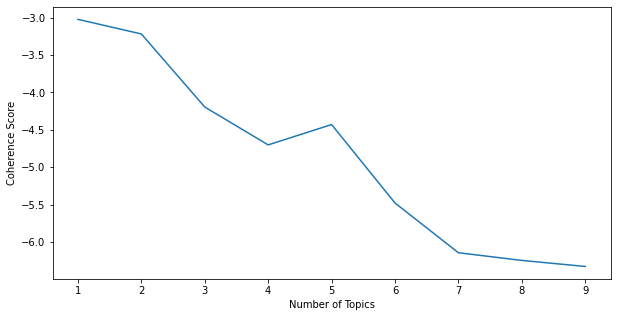

In [ ]:
# build a dictionary where for each tweet, each word has its own id.
statements_dictionary = Dictionary(clean_train_df.tokenized_statement)

# build the corpus i.e. vectors with the number of occurence of each word per tweet
statements_corpus = [statements_dictionary.doc2bow(tweet) for tweet in clean_train_df.tokenized_statement]

# compute coherence
statements_coherence = []
for nb_topics in range(1,10):
    lda = LdaModel(statements_corpus, num_topics = nb_topics, id2word = statements_dictionary, passes=10)
    cohm = CoherenceModel(model=lda, corpus=statements_corpus, dictionary=statements_dictionary, coherence='u_mass')
    coh = cohm.get_coherence()
    statements_coherence.append(coh)

# visualize coherence
plt.figure(figsize=(10,5))
plt.plot(range(1,10),statements_coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score");

###### Found k == 4, train the model and show the top words in each topic

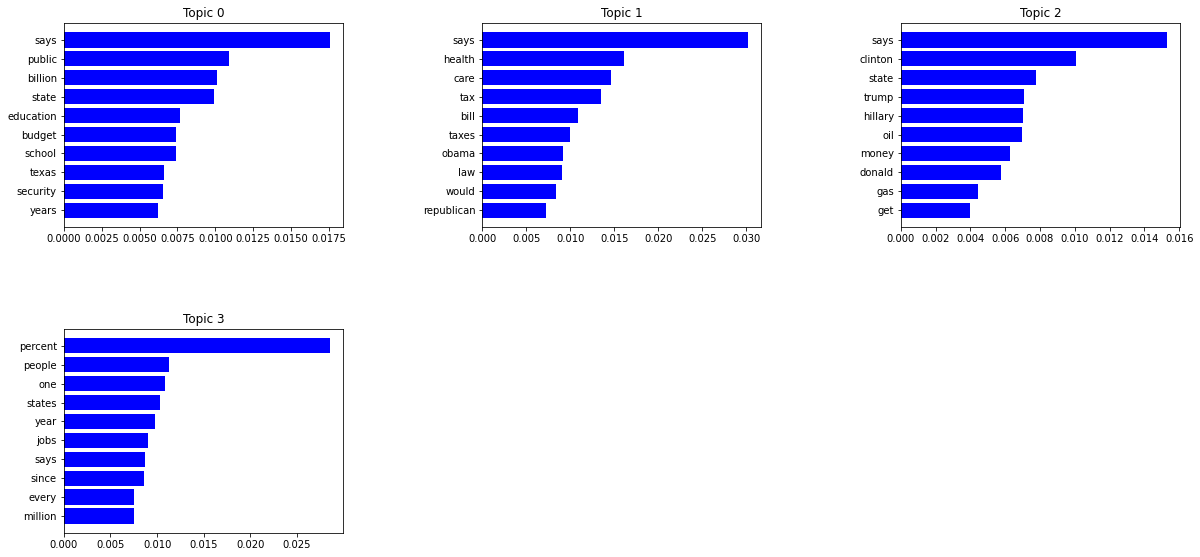

In [ ]:
k = 4
statements_lda = LdaModel(statements_corpus, num_topics = k, id2word = statements_dictionary, passes=10)

def plot_top_words(lda=statements_lda, nb_topics=k, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=0.5, hspace=0.5)
    plt.figure(figsize=(20,15))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))
        
  
plot_top_words()

###### Add the topic prediction back to data

In [ ]:
topics1 = []
topics2 = []
topics3 = []
topics4 = []

tpv = statements_lda[statements_corpus]
for statement in tpv:
    c1 = c2 = c3 = c4 = False
    for topic in statement:
        if topic[0] == 0:
            c1 = True
            topics1.append(topic[1])
        if topic[0] == 1:
            c2 = True
            topics2.append(topic[1])
        if topic[0] == 2:
            c3 = True
            topics3.append(topic[1])
        if topic[0] == 3:
            c4 = True
            topics4.append(topic[1])
    
    if not c1:
        topics1.append(0)
    if not c2:
        topics2.append(0)
    if not c3:
        topics3.append(0)
    if not c4:
        topics4.append(0)

In [ ]:
train_df_prepro['Topic1'] = topics1
train_df_prepro['Topic2'] = topics2
train_df_prepro['Topic3'] = topics3
train_df_prepro['Topic4'] = topics4

train_df_prepro

,1,CC,CD,DT,EX,FW,IN,JJ,LS,MD,NN,PDT,POS,PRP,RB,RP,SYM,TO,UH,VB,WH,SA_C,SA_P,SA_NU,SA_NG,Topic1,Topic2,Topic3,Topic4
0,false,0,0,1,0,0,1,1,0,0,6,0,0,0,0,0,1,0,0,2,0,0.2500,0.192,0.692,0.115,0.022888,0.713058,0.134852,0.129201
1,half-true,0,0,1,0,0,3,1,0,0,9,0,0,1,0,1,4,1,0,5,2,0.3612,0.098,0.902,0.000,0.018377,0.018442,0.944615,0.018567
2,mostly-true,0,0,2,0,0,4,0,0,0,9,0,0,0,0,0,3,1,0,3,0,0.3182,0.206,0.687,0.107,0.018303,0.203720,0.335839,0.442138
3,false,0,0,0,0,0,0,2,0,0,7,0,0,0,0,0,1,1,0,2,0,0.7579,0.394,0.606,0.000,0.025141,0.581741,0.097716,0.295402
4,half-true,0,0,2,0,0,2,1,0,0,3,0,0,1,0,0,1,0,0,1,0,0.0000,0.000,1.000,0.000,0.044136,0.049417,0.044613,0.861835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,mostly-true,0,0,1,2,0,4,1,0,0,7,0,0,0,0,0,1,0,0,2,0,-0.7506,0.062,0.619,0.319,0.029072,0.028745,0.416791,0.525392
10236,mostly-true,1,0,2,0,0,2,0,0,0,8,0,0,0,1,0,1,0,0,2,0,0.4019,0.172,0.828,0.000,0.903075,0.034142,0.031280,0.031503
10237,half-true,0,0,2,0,0,5,2,0,1,11,0,0,0,0,0,3,1,0,5,1,0.5859,0.161,0.839,0.000,0.762796,0.014956,0.207354,0.014894
10238,false,1,0,1,0,0,1,0,0,0,5,0,0,0,0,0,1,1,0,2,0,0.0000,0.000,1.000,0.000,0.471576,0.035720,0.175998,0.316706


In [ ]:
#target_labels = ['barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire', 'true']
#X_train = train_df_prepro.drop(target_labels, axis=1)
#y_train = train_df_prepro[target_labels]

X_train = train_df_prepro.drop(1, axis=1)
y_train = train_df_prepro[1]

##### Test data

In [ ]:
# build a dictionary where for each tweet, each word has its own id.
statements_dictionary = Dictionary(clean_test_df.tokenized_statement)

# build the corpus i.e. vectors with the number of occurence of each word per tweet
statements_corpus = [statements_dictionary.doc2bow(tweet) for tweet in clean_test_df.tokenized_statement]

###### Add the topic prediction back to data

In [ ]:
topics1 = []
topics2 = []
topics3 = []
topics4 = []

tpv = statements_lda[statements_corpus]
for statement in tpv:
    c1 = c2 = c3 = c4 = False
    for topic in statement:
        if topic[0] == 0:
            c1 = True
            topics1.append(topic[1])
        if topic[0] == 1:
            c2 = True
            topics2.append(topic[1])
        if topic[0] == 2:
            c3 = True
            topics3.append(topic[1])
        if topic[0] == 3:
            c4 = True
            topics4.append(topic[1])
    
    if not c1:
        topics1.append(0)
    if not c2:
        topics2.append(0)
    if not c3:
        topics3.append(0)
    if not c4:
        topics4.append(0)

In [ ]:
test_df_prepro['Topic1'] = topics1
test_df_prepro['Topic2'] = topics2
test_df_prepro['Topic3'] = topics3
test_df_prepro['Topic4'] = topics4

test_df_prepro

,1,CC,CD,DT,EX,FW,IN,JJ,LS,MD,NN,PDT,POS,PRP,RB,RP,SYM,TO,UH,VB,WH,SA_C,SA_P,SA_NU,SA_NG,Topic1,Topic2,Topic3,Topic4
0,true,0,0,2,0,0,1,0,0,1,4,0,0,0,1,0,1,0,0,2,0,0.0000,0.000,1.000,0.000,0.031507,0.762453,0.174304,0.031735
1,false,0,0,2,0,0,2,0,0,0,5,0,0,0,0,0,1,1,0,2,0,0.0772,0.106,0.894,0.000,0.037126,0.584800,0.039759,0.338315
2,false,0,0,1,0,0,0,0,0,0,4,0,0,0,0,0,1,1,0,4,0,-0.3089,0.000,0.799,0.201,0.032364,0.032104,0.902675,0.032857
3,half-true,0,0,1,0,0,1,0,0,1,7,0,0,0,0,0,1,0,0,2,1,0.3400,0.288,0.577,0.135,0.025989,0.027621,0.324948,0.621442
4,pants-fire,0,0,3,0,0,4,1,0,0,9,0,0,0,0,0,3,1,1,3,1,-0.5994,0.099,0.659,0.242,0.015933,0.516470,0.246354,0.221243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,half-true,0,0,1,0,0,2,1,0,0,6,0,0,1,0,0,1,0,0,2,0,0.0000,0.000,1.000,0.000,0.025713,0.025898,0.583996,0.364392
1263,barely-true,0,0,1,0,0,0,0,0,0,2,0,0,0,2,0,1,0,0,1,0,0.0000,0.000,1.000,0.000,0.831411,0.051925,0.050925,0.065739
1264,barely-true,0,1,2,0,0,2,3,0,0,8,0,0,0,1,0,2,1,0,3,0,0.4019,0.119,0.881,0.000,0.334381,0.323824,0.325299,0.016496
1265,barely-true,1,1,1,0,0,2,1,0,0,6,0,0,2,0,0,1,0,0,4,0,0.0000,0.000,1.000,0.000,0.216641,0.127709,0.635899,0.019751


In [ ]:
#target_labels = ['barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire', 'true']
#X_test = test_df_prepro.drop(target_labels, axis=1)
#y_test = test_df_prepro[target_labels]

X_test = test_df_prepro.drop(1, axis=1)
y_test = test_df_prepro[1]

##### Train models

###### Different Classifiers

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from time import time

In [ ]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", #"Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

In [ ]:
classifiers = [
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025, probability=True, random_state=0),
    SVC(gamma=2, C=1, probability=True, random_state=0),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5, random_state=0),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=0),
    MLPClassifier(alpha=1, max_iter=1000, random_state=0),
    AdaBoostClassifier(random_state=0),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

###### Muller loop

In [ ]:
max_score = 0.0
max_class = ''
for name, clf in zip(names, classifiers):
    start_time = time()
    clf.fit(X_train, y_train)
    score = 100.0 * clf.score(X_test, y_test)
    print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time() - start_time))
    
    if score > max_score:
        clf_best_percData = clf
        max_score = score
        max_class = name

print(80*'-' )
print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))

Classifier = Nearest Neighbors, Score (test, accuracy) = 21.47, Training time = 0.36 seconds
Classifier = Linear SVM, Score (test, accuracy) = 23.84, Training time = 42.76 seconds
Classifier = RBF SVM, Score (test, accuracy) = 20.76, Training time = 87.46 seconds
Classifier = Decision Tree, Score (test, accuracy) = 22.10, Training time = 0.07 seconds
Classifier = Random Forest, Score (test, accuracy) = 22.97, Training time = 0.07 seconds
Classifier = Neural Net, Score (test, accuracy) = 23.84, Training time = 9.57 seconds
Classifier = AdaBoost, Score (test, accuracy) = 22.65, Training time = 1.52 seconds
Classifier = Naive Bayes, Score (test, accuracy) = 14.76, Training time = 0.02 seconds
Classifier = QDA, Score (test, accuracy) = 10.42, Training time = 0.04 seconds
--------------------------------------------------------------------------------
Best --> Classifier = Linear SVM, Score (test, accuracy) = 23.84


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


###### Feature importance

In [ ]:
pd.Series(classifiers[4].feature_importances_,X_train.columns).sort_values(ascending=False)

Topic4    0.161349
CD        0.071364
SA_C      0.069784
Topic3    0.060619
SA_P      0.049566
TO        0.046933
JJ        0.046227
DT        0.045385
Topic2    0.042656
VB        0.040437
SA_NG     0.039620
IN        0.033992
SA_NU     0.032242
SYM       0.028453
Topic1    0.027407
EX        0.026783
PRP       0.026704
NN        0.026022
CC        0.023860
RB        0.023223
POS       0.018247
WH        0.017838
MD        0.011390
FW        0.010668
PDT       0.008401
RP        0.007102
UH        0.003729
LS        0.000000
dtype: float64

##### Conclusion

Adding topic predicted by LDA model seems not helping.

#### NER - spaCy

In [2]:
!python3 -m spacy download en_core_web_lg

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [3]:
# Restart runtime before running this cell
import spacy
sp_lg = spacy.load('en_core_web_lg') 

In [4]:
def spacy_large_ner(document):
    return [ent.label_ for ent in sp_lg(document).ents]

In [30]:
def ner_counter(ner_list):
    pers = 0
    norp = 0
    fac = 0
    org = 0
    gpe = 0
    loc = 0
    prod = 0
    eve = 0
    woa = 0
    law = 0
    lang = 0
    dat = 0
    tim = 0
    per = 0
    mon = 0
    quan = 0
    ordi = 0
    cardi = 0

    for n in ner_list:
        if n == 'PERSON':
            pers += 1
        elif n == 'NORP':
            norp += 1
        elif n == 'FAC':
            fac += 1
        elif n == 'ORG':
            org += 1
        elif n == 'GPE':
            gpe += 1
        elif n == 'LOC':
            loc += 1
        elif n == 'PRODUCT':
            prod += 1
        elif n == 'EVENT':
            eve += 1
        elif n == 'WORK_OF_ART':
            woa += 1
        elif n == 'LAW':
            law += 1
        elif n == 'LANGUAGE':
            lang += 1
        elif n == 'DATE':
            dat += 1
        elif n == 'TIME':
            tim += 1
        elif n == 'PERCENT':
            per += 1
        elif n == 'MONEY':
            mon += 1
        elif n == 'QUANTITY':
            quan += 1
        elif n == 'ORDINAL':
            ordi += 1
        elif n == 'CARDINAL':
            cardi += 1
    return [pers, norp, fac, org, gpe, loc, prod, eve, woa, law, lang, dat, tim,\
            per, mon, quan, ordi, cardi]

##### Train data

In [ ]:
NER_pers = []
NER_norp = []
NER_fac = []
NER_org = []
NER_gpe = []
NER_loc = []
NER_prod = []
NER_eve = []
NER_woa = []
NER_law = []
NER_lang = []
NER_dat = []
NER_tim = []
NER_per = []
NER_mon = []
NER_quan = []
NER_ordi = []
NER_cardi = []

for statement in train_df[2]:
    ner_count = ner_counter(spacy_large_ner(statement))

    NER_pers.append(ner_count[0])
    NER_norp.append(ner_count[1])
    NER_fac.append(ner_count[2])
    NER_org.append(ner_count[3])
    NER_gpe.append(ner_count[4])
    NER_loc.append(ner_count[5])
    NER_prod.append(ner_count[6])
    NER_eve.append(ner_count[7])
    NER_woa.append(ner_count[8])
    NER_law.append(ner_count[9])
    NER_lang.append(ner_count[10])
    NER_dat.append(ner_count[11])
    NER_tim.append(ner_count[12])
    NER_per.append(ner_count[13])
    NER_mon.append(ner_count[14])
    NER_quan.append(ner_count[15])
    NER_ordi.append(ner_count[16])
    NER_cardi.append(ner_count[17])

Concate after combined POS counting and Sentiment Analysis

In [ ]:
train_df_prepro['NER_pers'] = NER_pers
train_df_prepro['NER_norp'] = NER_norp
train_df_prepro['NER_fac'] = NER_fac
train_df_prepro['NER_org'] = NER_org
train_df_prepro['NER_gpe'] = NER_gpe
train_df_prepro['NER_loc'] = NER_loc
train_df_prepro['NER_prod'] = NER_prod
train_df_prepro['NER_eve'] = NER_eve
train_df_prepro['NER_woa'] = NER_woa
train_df_prepro['NER_law'] = NER_law
train_df_prepro['NER_lang'] = NER_lang
train_df_prepro['NER_dat'] = NER_dat
train_df_prepro['NER_tim'] = NER_tim
train_df_prepro['NER_per'] = NER_per
train_df_prepro['NER_mon'] = NER_mon
train_df_prepro['NER_quan'] = NER_quan
train_df_prepro['NER_ordi'] = NER_ordi
train_df_prepro['NER_cardi'] = NER_cardi

train_df_prepro

,1,CC,CD,DT,EX,FW,IN,JJ,LS,MD,NN,PDT,POS,PRP,RB,RP,SYM,TO,UH,VB,WH,SA_C,SA_P,SA_NU,SA_NG,NER_pers,NER_norp,NER_fac,NER_org,NER_gpe,NER_loc,NER_prod,NER_eve,NER_woa,NER_law,NER_lang,NER_dat,NER_tim,NER_per,NER_mon,NER_quan,NER_ordi,NER_cardi
0,false,0,0,1,0,0,1,1,0,0,6,0,0,0,0,0,1,0,0,2,0,0.2500,0.192,0.692,0.115,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,half-true,0,0,1,0,0,3,1,0,0,9,0,0,1,0,1,4,1,0,5,2,0.3612,0.098,0.902,0.000,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,mostly-true,0,0,2,0,0,4,0,0,0,9,0,0,0,0,0,3,1,0,3,0,0.3182,0.206,0.687,0.107,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,false,0,0,0,0,0,0,2,0,0,7,0,0,0,0,0,1,1,0,2,0,0.7579,0.394,0.606,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,half-true,0,0,2,0,0,2,1,0,0,3,0,0,1,0,0,1,0,0,1,0,0.0000,0.000,1.000,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,mostly-true,0,0,1,2,0,4,1,0,0,7,0,0,0,0,0,1,0,0,2,0,-0.7506,0.062,0.619,0.319,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
10236,mostly-true,1,0,2,0,0,2,0,0,0,8,0,0,0,1,0,1,0,0,2,0,0.4019,0.172,0.828,0.000,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
10237,half-true,0,0,2,0,0,5,2,0,1,11,0,0,0,0,0,3,1,0,5,1,0.5859,0.161,0.839,0.000,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0
10238,false,1,0,1,0,0,1,0,0,0,5,0,0,0,0,0,1,1,0,2,0,0.0000,0.000,1.000,0.000,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#target_labels = ['barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire', 'true']
#X_train = train_df_prepro.drop(target_labels, axis=1)
#y_train = train_df_prepro[target_labels]

X_train = train_df_prepro.drop(1, axis=1)
y_train = train_df_prepro[1]

##### Test data

In [ ]:
NER_pers = []
NER_norp = []
NER_fac = []
NER_org = []
NER_gpe = []
NER_loc = []
NER_prod = []
NER_eve = []
NER_woa = []
NER_law = []
NER_lang = []
NER_dat = []
NER_tim = []
NER_per = []
NER_mon = []
NER_quan = []
NER_ordi = []
NER_cardi = []

for statement in test_df[2]:
    ner_count = ner_counter(spacy_large_ner(statement))

    NER_pers.append(ner_count[0])
    NER_norp.append(ner_count[1])
    NER_fac.append(ner_count[2])
    NER_org.append(ner_count[3])
    NER_gpe.append(ner_count[4])
    NER_loc.append(ner_count[5])
    NER_prod.append(ner_count[6])
    NER_eve.append(ner_count[7])
    NER_woa.append(ner_count[8])
    NER_law.append(ner_count[9])
    NER_lang.append(ner_count[10])
    NER_dat.append(ner_count[11])
    NER_tim.append(ner_count[12])
    NER_per.append(ner_count[13])
    NER_mon.append(ner_count[14])
    NER_quan.append(ner_count[15])
    NER_ordi.append(ner_count[16])
    NER_cardi.append(ner_count[17])

Concate after combined POS counting and Sentiment Analysis

In [ ]:
test_df_prepro['NER_pers'] = NER_pers
test_df_prepro['NER_norp'] = NER_norp
test_df_prepro['NER_fac'] = NER_fac
test_df_prepro['NER_org'] = NER_org
test_df_prepro['NER_gpe'] = NER_gpe
test_df_prepro['NER_loc'] = NER_loc
test_df_prepro['NER_prod'] = NER_prod
test_df_prepro['NER_eve'] = NER_eve
test_df_prepro['NER_woa'] = NER_woa
test_df_prepro['NER_law'] = NER_law
test_df_prepro['NER_lang'] = NER_lang
test_df_prepro['NER_dat'] = NER_dat
test_df_prepro['NER_tim'] = NER_tim
test_df_prepro['NER_per'] = NER_per
test_df_prepro['NER_mon'] = NER_mon
test_df_prepro['NER_quan'] = NER_quan
test_df_prepro['NER_ordi'] = NER_ordi
test_df_prepro['NER_cardi'] = NER_cardi

test_df_prepro

,1,CC,CD,DT,EX,FW,IN,JJ,LS,MD,NN,PDT,POS,PRP,RB,RP,SYM,TO,UH,VB,WH,SA_C,SA_P,SA_NU,SA_NG,NER_pers,NER_norp,NER_fac,NER_org,NER_gpe,NER_loc,NER_prod,NER_eve,NER_woa,NER_law,NER_lang,NER_dat,NER_tim,NER_per,NER_mon,NER_quan,NER_ordi,NER_cardi
0,true,0,0,2,0,0,1,0,0,1,4,0,0,0,1,0,1,0,0,2,0,0.0000,0.000,1.000,0.000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,false,0,0,2,0,0,2,0,0,0,5,0,0,0,0,0,1,1,0,2,0,0.0772,0.106,0.894,0.000,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,false,0,0,1,0,0,0,0,0,0,4,0,0,0,0,0,1,1,0,4,0,-0.3089,0.000,0.799,0.201,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,half-true,0,0,1,0,0,1,0,0,1,7,0,0,0,0,0,1,0,0,2,1,0.3400,0.288,0.577,0.135,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,pants-fire,0,0,3,0,0,4,1,0,0,9,0,0,0,0,0,3,1,1,3,1,-0.5994,0.099,0.659,0.242,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,half-true,0,0,1,0,0,2,1,0,0,6,0,0,1,0,0,1,0,0,2,0,0.0000,0.000,1.000,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1263,barely-true,0,0,1,0,0,0,0,0,0,2,0,0,0,2,0,1,0,0,1,0,0.0000,0.000,1.000,0.000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1264,barely-true,0,1,2,0,0,2,3,0,0,8,0,0,0,1,0,2,1,0,3,0,0.4019,0.119,0.881,0.000,2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1265,barely-true,1,1,1,0,0,2,1,0,0,6,0,0,2,0,0,1,0,0,4,0,0.0000,0.000,1.000,0.000,1,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
#target_labels = ['barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire', 'true']
#X_test = test_df_prepro.drop(target_labels, axis=1)
#y_test = test_df_prepro[target_labels]

X_test = test_df_prepro.drop(1, axis=1)
y_test = test_df_prepro[1]

##### Train models

###### Different Classifiers

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from time import time

In [ ]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", #"Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

In [ ]:
classifiers = [
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025, probability=True, random_state=0),
    SVC(gamma=2, C=1, probability=True, random_state=0),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5, random_state=0),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=0),
    MLPClassifier(alpha=1, max_iter=1000, random_state=0),
    AdaBoostClassifier(random_state=0),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

###### Muller loop

In [ ]:
max_score = 0.0
max_class = ''
for name, clf in zip(names, classifiers):
    start_time = time()
    clf.fit(X_train, y_train)
    score = 100.0 * clf.score(X_test, y_test)
    print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time() - start_time))
    
    if score > max_score:
        clf_best_percData = clf
        max_score = score
        max_class = name

print(80*'-' )
print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))

Classifier = Nearest Neighbors, Score (test, accuracy) = 21.70, Training time = 0.66 seconds
Classifier = Linear SVM, Score (test, accuracy) = 25.41, Training time = 60.04 seconds
Classifier = RBF SVM, Score (test, accuracy) = 21.15, Training time = 114.02 seconds
Classifier = Decision Tree, Score (test, accuracy) = 23.76, Training time = 0.06 seconds
Classifier = Random Forest, Score (test, accuracy) = 24.63, Training time = 0.06 seconds
Classifier = Neural Net, Score (test, accuracy) = 25.73, Training time = 16.06 seconds
Classifier = AdaBoost, Score (test, accuracy) = 24.07, Training time = 1.33 seconds
Classifier = Naive Bayes, Score (test, accuracy) = 8.68, Training time = 0.03 seconds
Classifier = QDA, Score (test, accuracy) = 7.66, Training time = 0.06 seconds
--------------------------------------------------------------------------------
Best --> Classifier = Neural Net, Score (test, accuracy) = 25.73


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


###### Feature importance

In [ ]:
pd.Series(classifiers[4].feature_importances_,X_train.columns).sort_values(ascending=False)

SA_C         0.083286
CD           0.082639
NER_cardi    0.065084
TO           0.054319
SA_NU        0.049475
NN           0.047929
NER_dat      0.047202
NER_mon      0.040731
NER_org      0.040092
NER_pers     0.035624
RB           0.034286
PRP          0.028565
VB           0.027108
SA_P         0.026947
WH           0.025640
SA_NG        0.024396
CC           0.022569
NER_norp     0.021750
EX           0.021653
NER_woa      0.018197
NER_law      0.017126
RP           0.016891
NER_fac      0.016452
MD           0.015968
NER_eve      0.015767
DT           0.014572
NER_gpe      0.013783
NER_ordi     0.012151
SYM          0.012076
NER_per      0.011682
JJ           0.010177
NER_loc      0.009039
UH           0.008803
NER_quan     0.007640
NER_lang     0.005204
FW           0.004486
IN           0.003833
POS          0.003624
NER_tim      0.002382
PDT          0.000853
LS           0.000000
NER_prod     0.000000
dtype: float64

##### Conclusion

We get the best outcome by far. Accuracy up to 25.73% using Combined POS, Sentiment Analysis and NER.

### Amalgamation - Liar-Plus dataset (Add up both statement and justification)

https://drive.google.com/file/d/1sFMftHLILNfuS0kpTlsbUzWpSNs3WkeD/view?usp=sharing

In [5]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1sFMftHLILNfuS0kpTlsbUzWpSNs3WkeD"})
downloaded.GetContentFile('liar_plus_dataset.zip')

In [6]:
from zipfile import ZipFile

In [10]:
with ZipFile('liar_plus_dataset.zip', 'r') as myzip:
    train_data = myzip.open('train2.tsv')
    test_data = myzip.open('test2.tsv')
    valid_data = myzip.open('val2.tsv')

train_p_df = pd.read_csv(train_data, sep='\t', header=None).drop([0], axis=1).dropna(how='all')
test_p_df = pd.read_csv(test_data, sep='\t', header=None).drop([0], axis=1).dropna(how='all')
valid_p_df = pd.read_csv(valid_data, sep='\t', header=None).drop([0], axis=1).dropna(how='all')

In [80]:
train_p_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."


#### Train data

##### Transforming token to pos tag and to pos count

In [11]:
train_postags = []
for i, c in enumerate(train_p_df[3]):
    train_postags.append(nltk.pos_tag(nltk.word_tokenize(c)))
    if i < 5:
        print(train_postags[-1])

[('Says', 'VBZ'), ('the', 'DT'), ('Annies', 'NNPS'), ('List', 'NNP'), ('political', 'JJ'), ('group', 'NN'), ('supports', 'VBZ'), ('third-trimester', 'NN'), ('abortions', 'NNS'), ('on', 'IN'), ('demand', 'NN'), ('.', '.')]
[('When', 'WRB'), ('did', 'VBD'), ('the', 'DT'), ('decline', 'NN'), ('of', 'IN'), ('coal', 'NN'), ('start', 'NN'), ('?', '.'), ('It', 'PRP'), ('started', 'VBD'), ('when', 'WRB'), ('natural', 'JJ'), ('gas', 'NN'), ('took', 'VBD'), ('off', 'RP'), ('that', 'IN'), ('started', 'VBD'), ('to', 'TO'), ('begin', 'VB'), ('in', 'IN'), ('(', '('), ('President', 'NNP'), ('George', 'NNP'), ('W.', 'NNP'), (')', ')'), ('Bushs', 'NNP'), ('administration', 'NN'), ('.', '.')]
[('Hillary', 'NNP'), ('Clinton', 'NNP'), ('agrees', 'VBZ'), ('with', 'IN'), ('John', 'NNP'), ('McCain', 'NNP'), ('``', '``'), ('by', 'IN'), ('voting', 'VBG'), ('to', 'TO'), ('give', 'VB'), ('George', 'NNP'), ('Bush', 'NNP'), ('the', 'DT'), ('benefit', 'NN'), ('of', 'IN'), ('the', 'DT'), ('doubt', 'NN'), ('on', 'IN'

In [12]:
train_tag_counters = []

for tags in train_postags:
    tag_counter = {
        '$': 0,
        "''": 0,
        '(': 0,
        ')': 0,
        ',': 0,
        '--': 0,
        '.': 0,
        ':': 0,
        'CC': 0,
        'CD': 0,
        'DT': 0,
        'EX': 0,
        'FW': 0,
        'IN': 0,
        'JJ': 0,
        'JJR': 0,
        'JJS': 0,
        'LS': 0,
        'MD': 0,
        'NN': 0,
        'NNP': 0,
        'NNPS': 0,
        'NNS': 0,
        'PDT': 0,
        'POS': 0,
        'PRP': 0,
        'PRP$': 0,
        'RB': 0,
        'RBR': 0,
        'RBS': 0,
        'RP': 0,
        'SYM': 0,
        'TO': 0,
        'UH': 0,
        'VB': 0,
        'VBD': 0,
        'VBG': 0,
        'VBN': 0,
        'VBP': 0,
        'VBZ': 0,
        'WDT': 0,
        'WP': 0,
        'WP$': 0,
        'WRB': 0,
        '``': 0,
        '#': 0
    }
    for tag in tags:
        if tag[1] in tag_counter:
            tag_counter[tag[1]] += 1
        else:
            print(tag)
    train_tag_counters.append(tag_counter)

In [13]:
train_postags = []
for i, c in enumerate(train_p_df[15]):
    if isinstance(c, str): train_postags.append(nltk.pos_tag(nltk.word_tokenize(c)))
    else: train_postags.append([])
    if i < 5:
        print(train_postags[-1])

[('That', 'DT'), ("'s", 'VBZ'), ('a', 'DT'), ('premise', 'NN'), ('that', 'IN'), ('he', 'PRP'), ('fails', 'VBZ'), ('to', 'TO'), ('back', 'VB'), ('up', 'RP'), ('.', '.'), ('Annie', 'NNP'), ("'s", 'POS'), ('List', 'NNP'), ('makes', 'VBZ'), ('no', 'DT'), ('bones', 'NNS'), ('about', 'IN'), ('being', 'VBG'), ('comfortable', 'JJ'), ('with', 'IN'), ('candidates', 'NNS'), ('who', 'WP'), ('oppose', 'VBP'), ('further', 'JJ'), ('restrictions', 'NNS'), ('on', 'IN'), ('late-term', 'JJ'), ('abortions', 'NNS'), ('.', '.'), ('Then', 'RB'), ('again', 'RB'), (',', ','), ('this', 'DT'), ('year', 'NN'), ('its', 'PRP$'), ('backing', 'NN'), ('two', 'CD'), ('House', 'NNP'), ('candidates', 'NNS'), ('who', 'WP'), ('voted', 'VBD'), ('for', 'IN'), ('more', 'RBR'), ('limits', 'NNS'), ('.', '.')]
[('Surovell', 'NNP'), ('said', 'VBD'), ('the', 'DT'), ('decline', 'NN'), ('of', 'IN'), ('coal', 'NN'), ('``', '``'), ('started', 'VBD'), ('when', 'WRB'), ('natural', 'JJ'), ('gas', 'NN'), ('took', 'VBD'), ('off', 'RP'), ('

In [14]:
for i, tags in enumerate(train_postags):
    for tag in tags:
        if tag[1] in train_tag_counters[i]:
            train_tag_counters[i][tag[1]] += 1
        else:
            print(tag)

##### Combining

In [33]:
ccl = []
cdl = []
dtl = []
exl = []
fwl = []
inl = []
jjl = []
lsl = []
mdl = []
nnl = []
pdtl = []
posl = []
prpl = []
rbl = []
rpl = []
syml = []
tol = []
uhl = []
vbl = []
whl = []

for tct in train_tag_counters:
    tct_values = list(tct.values())
    ccl.append(tct_values[8])
    cdl.append(tct_values[9])
    dtl.append(tct_values[10])
    exl.append(tct_values[11])
    fwl.append(tct_values[12])
    inl.append(tct_values[13])
    jjl.append(tct_values[14]+tct_values[15]+tct_values[16])
    lsl.append(tct_values[17])
    mdl.append(tct_values[18])
    nnl.append(tct_values[19]+tct_values[20]+tct_values[21]+tct_values[22])
    pdtl.append(tct_values[23])
    posl.append(tct_values[24])
    prpl.append(tct_values[25]+tct_values[26])
    rbl.append(tct_values[27]+tct_values[28]+tct_values[29])
    rpl.append(tct_values[30])
    syml.append(tct_values[0]+tct_values[1]+tct_values[2]+tct_values[3]+
                tct_values[4]+tct_values[5]+tct_values[6]+tct_values[7]+
                tct_values[31]+tct_values[44]+tct_values[45])
    tol.append(tct_values[32])
    uhl.append(tct_values[33])
    vbl.append(tct_values[34]+tct_values[35]+tct_values[36]+tct_values[37]+
               tct_values[38]+tct_values[39])
    whl.append(tct_values[40]+tct_values[41]+tct_values[42]+tct_values[43])

In [34]:
#train_df_prepro = pd.get_dummies(train_df[1], columns=1)
train_df_prepro = train_p_df.loc[:, [2]]

In [35]:
train_df_prepro['CC'] = ccl
train_df_prepro['CD'] = cdl
train_df_prepro['DT'] = dtl
train_df_prepro['EX'] = exl
train_df_prepro['FW'] = fwl
train_df_prepro['IN'] = inl
train_df_prepro['JJ'] = jjl
train_df_prepro['LS'] = lsl
train_df_prepro['MD'] = mdl
train_df_prepro['NN'] = nnl
train_df_prepro['PDT'] = pdtl
train_df_prepro['POS'] = posl
train_df_prepro['PRP'] = prpl
train_df_prepro['RB'] = rbl
train_df_prepro['RP'] = rpl
train_df_prepro['SYM'] = syml
train_df_prepro['TO'] = tol
train_df_prepro['UH'] = uhl
train_df_prepro['VB'] = vbl
train_df_prepro['WH'] = whl

train_df_prepro

,2,CC,CD,DT,EX,FW,IN,JJ,LS,MD,NN,PDT,POS,PRP,RB,RP,SYM,TO,UH,VB,WH
0,false,0,1,5,0,0,6,4,0,0,18,0,1,2,3,1,5,1,0,9,2
1,half-true,4,1,12,0,0,17,10,0,0,43,0,0,2,2,3,19,4,0,23,4
2,mostly-true,3,0,10,0,0,16,6,0,2,27,0,1,4,3,0,13,2,0,20,0
3,false,5,0,9,1,0,7,11,0,6,36,0,0,3,4,0,10,4,0,18,2
4,half-true,6,0,8,0,0,16,12,0,0,32,0,0,5,4,0,10,0,0,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10237,mostly-true,1,0,2,2,0,8,3,0,0,11,0,0,4,3,0,5,1,0,7,0
10238,mostly-true,2,2,6,0,0,10,5,0,1,21,0,0,4,4,0,10,2,0,10,0
10239,half-true,3,0,6,0,0,12,5,0,1,26,0,0,2,1,1,10,3,0,14,2
10240,false,5,7,11,0,0,13,4,0,1,19,0,1,8,15,1,19,4,0,21,1


##### Sentiment Analysis

In [26]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [36]:
sid = SentimentIntensityAnalyzer()

SA_C = []
SA_P = []
SA_NU = []
SA_NG = []

for sentence, justification in zip(train_p_df[3], train_p_df[15]):
    ss = sid.polarity_scores(sentence+str(justification))
    for k in sorted(ss):
        if k == 'compound':
            SA_C.append(ss[k])
        elif k == 'pos':
            SA_P.append(ss[k])
        elif k == 'neu':
            SA_NU.append(ss[k])
        elif k == 'neg':
            SA_NG.append(ss[k])

In [37]:
train_df_prepro['SA_C'] = SA_C
train_df_prepro['SA_P'] = SA_P
train_df_prepro['SA_NU'] = SA_NU
train_df_prepro['SA_NG'] = SA_NG

train_df_prepro

,2,CC,CD,DT,EX,FW,IN,JJ,LS,MD,NN,PDT,POS,PRP,RB,RP,SYM,TO,UH,VB,WH,SA_C,SA_P,SA_NU,SA_NG
0,false,0,1,5,0,0,6,4,0,0,18,0,1,2,3,1,5,1,0,9,2,0.2263,0.123,0.787,0.089
1,half-true,4,1,12,0,0,17,10,0,0,43,0,0,2,2,3,19,4,0,23,4,0.9633,0.186,0.772,0.042
2,mostly-true,3,0,10,0,0,16,6,0,2,27,0,1,4,3,0,13,2,0,20,0,0.4588,0.101,0.828,0.071
3,false,5,0,9,1,0,7,11,0,6,36,0,0,3,4,0,10,4,0,18,2,0.6435,0.127,0.774,0.099
4,half-true,6,0,8,0,0,16,12,0,0,32,0,0,5,4,0,10,0,0,12,0,0.4384,0.070,0.910,0.020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10237,mostly-true,1,0,2,2,0,8,3,0,0,11,0,0,4,3,0,5,1,0,7,0,-0.6486,0.029,0.846,0.125
10238,mostly-true,2,2,6,0,0,10,5,0,1,21,0,0,4,4,0,10,2,0,10,0,0.1779,0.092,0.839,0.068
10239,half-true,3,0,6,0,0,12,5,0,1,26,0,0,2,1,1,10,3,0,14,2,0.9001,0.171,0.829,0.000
10240,false,5,7,11,0,0,13,4,0,1,19,0,1,8,15,1,19,4,0,21,1,0.7783,0.062,0.938,0.000


##### NER - spaCy

In [38]:
NER_pers = []
NER_norp = []
NER_fac = []
NER_org = []
NER_gpe = []
NER_loc = []
NER_prod = []
NER_eve = []
NER_woa = []
NER_law = []
NER_lang = []
NER_dat = []
NER_tim = []
NER_per = []
NER_mon = []
NER_quan = []
NER_ordi = []
NER_cardi = []

for statement in train_p_df[3]:
    ner_count = ner_counter(spacy_large_ner(statement))

    NER_pers.append(ner_count[0])
    NER_norp.append(ner_count[1])
    NER_fac.append(ner_count[2])
    NER_org.append(ner_count[3])
    NER_gpe.append(ner_count[4])
    NER_loc.append(ner_count[5])
    NER_prod.append(ner_count[6])
    NER_eve.append(ner_count[7])
    NER_woa.append(ner_count[8])
    NER_law.append(ner_count[9])
    NER_lang.append(ner_count[10])
    NER_dat.append(ner_count[11])
    NER_tim.append(ner_count[12])
    NER_per.append(ner_count[13])
    NER_mon.append(ner_count[14])
    NER_quan.append(ner_count[15])
    NER_ordi.append(ner_count[16])
    NER_cardi.append(ner_count[17])

for i, justification in enumerate(train_p_df[15]):
    ner_count = ner_counter(spacy_large_ner(str(justification)))

    NER_pers[i] += ner_count[0]
    NER_norp[i] += ner_count[1]
    NER_fac[i] += ner_count[2]
    NER_org[i] += ner_count[3]
    NER_gpe[i] += ner_count[4]
    NER_loc[i] += ner_count[5]
    NER_prod[i] += ner_count[6]
    NER_eve[i] += ner_count[7]
    NER_woa[i] += ner_count[8]
    NER_law[i] += ner_count[9]
    NER_lang[i] += ner_count[10]
    NER_dat[i] += ner_count[11]
    NER_tim[i] += ner_count[12]
    NER_per[i] += ner_count[13]
    NER_mon[i] += ner_count[14]
    NER_quan[i] += ner_count[15]
    NER_ordi[i] += ner_count[16]
    NER_cardi[i] += ner_count[17]

In [39]:
train_df_prepro['NER_pers'] = NER_pers
train_df_prepro['NER_norp'] = NER_norp
train_df_prepro['NER_fac'] = NER_fac
train_df_prepro['NER_org'] = NER_org
train_df_prepro['NER_gpe'] = NER_gpe
train_df_prepro['NER_loc'] = NER_loc
train_df_prepro['NER_prod'] = NER_prod
train_df_prepro['NER_eve'] = NER_eve
train_df_prepro['NER_woa'] = NER_woa
train_df_prepro['NER_law'] = NER_law
train_df_prepro['NER_lang'] = NER_lang
train_df_prepro['NER_dat'] = NER_dat
train_df_prepro['NER_tim'] = NER_tim
train_df_prepro['NER_per'] = NER_per
train_df_prepro['NER_mon'] = NER_mon
train_df_prepro['NER_quan'] = NER_quan
train_df_prepro['NER_ordi'] = NER_ordi
train_df_prepro['NER_cardi'] = NER_cardi

train_df_prepro

,2,CC,CD,DT,EX,FW,IN,JJ,LS,MD,NN,PDT,POS,PRP,RB,RP,SYM,TO,UH,VB,WH,SA_C,SA_P,SA_NU,SA_NG,NER_pers,NER_norp,NER_fac,NER_org,NER_gpe,NER_loc,NER_prod,NER_eve,NER_woa,NER_law,NER_lang,NER_dat,NER_tim,NER_per,NER_mon,NER_quan,NER_ordi,NER_cardi
0,false,0,1,5,0,0,6,4,0,0,18,0,1,2,3,1,5,1,0,9,2,0.2263,0.123,0.787,0.089,1,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,half-true,4,1,12,0,0,17,10,0,0,43,0,0,2,2,3,19,4,0,23,4,0.9633,0.186,0.772,0.042,6,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,mostly-true,3,0,10,0,0,16,6,0,2,27,0,1,4,3,0,13,2,0,20,0,0.4588,0.101,0.828,0.071,10,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0
3,false,5,0,9,1,0,7,11,0,6,36,0,0,3,4,0,10,4,0,18,2,0.6435,0.127,0.774,0.099,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,half-true,6,0,8,0,0,16,12,0,0,32,0,0,5,4,0,10,0,0,12,0,0.4384,0.070,0.910,0.020,3,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10237,mostly-true,1,0,2,2,0,8,3,0,0,11,0,0,4,3,0,5,1,0,7,0,-0.6486,0.029,0.846,0.125,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
10238,mostly-true,2,2,6,0,0,10,5,0,1,21,0,0,4,4,0,10,2,0,10,0,0.1779,0.092,0.839,0.068,1,2,0,3,1,0,0,0,0,0,0,1,0,0,0,0,0,1
10239,half-true,3,0,6,0,0,12,5,0,1,26,0,0,2,1,1,10,3,0,14,2,0.9001,0.171,0.829,0.000,0,0,0,4,3,0,0,0,1,0,0,1,0,0,0,0,0,0
10240,false,5,7,11,0,0,13,4,0,1,19,0,1,8,15,1,19,4,0,21,1,0.7783,0.062,0.938,0.000,0,1,0,3,2,0,0,0,0,0,0,2,0,0,3,0,1,0


In [41]:
#target_labels = ['barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire', 'true']
#X_train = train_df_prepro.drop(target_labels, axis=1)
#y_train = train_df_prepro[target_labels]

X_train = train_df_prepro.drop(2, axis=1)
y_train = train_df_prepro[2]

#### Test data

##### Transforming token to pos tag and to pos count

In [42]:
test_postags = []
for i, c in enumerate(test_p_df[3]):
    test_postags.append(nltk.pos_tag(nltk.word_tokenize(c)))
    if i < 5:
        print(test_postags[-1])

[('Building', 'VBG'), ('a', 'DT'), ('wall', 'NN'), ('on', 'IN'), ('the', 'DT'), ('U.S.-Mexico', 'NNP'), ('border', 'NN'), ('will', 'MD'), ('take', 'VB'), ('literally', 'RB'), ('years', 'NNS'), ('.', '.')]
[('Wisconsin', 'NNP'), ('is', 'VBZ'), ('on', 'IN'), ('pace', 'NN'), ('to', 'TO'), ('double', 'VB'), ('the', 'DT'), ('number', 'NN'), ('of', 'IN'), ('layoffs', 'NNS'), ('this', 'DT'), ('year', 'NN'), ('.', '.')]
[('Says', 'VBZ'), ('John', 'NNP'), ('McCain', 'NNP'), ('has', 'VBZ'), ('done', 'VBN'), ('nothing', 'NN'), ('to', 'TO'), ('help', 'VB'), ('the', 'DT'), ('vets', 'NNS'), ('.', '.')]
[('Suzanne', 'NNP'), ('Bonamici', 'NNP'), ('supports', 'VBZ'), ('a', 'DT'), ('plan', 'NN'), ('that', 'WDT'), ('will', 'MD'), ('cut', 'VB'), ('choice', 'NN'), ('for', 'IN'), ('Medicare', 'NNP'), ('Advantage', 'NNP'), ('seniors', 'NNS'), ('.', '.')]
[('When', 'WRB'), ('asked', 'VBN'), ('by', 'IN'), ('a', 'DT'), ('reporter', 'NN'), ('whether', 'IN'), ('hes', 'NNS'), ('at', 'IN'), ('the', 'DT'), ('center'

In [43]:
test_tag_counters = []

for tags in test_postags:
    tag_counter = {
        '$': 0,
        "''": 0,
        '(': 0,
        ')': 0,
        ',': 0,
        '--': 0,
        '.': 0,
        ':': 0,
        'CC': 0,
        'CD': 0,
        'DT': 0,
        'EX': 0,
        'FW': 0,
        'IN': 0,
        'JJ': 0,
        'JJR': 0,
        'JJS': 0,
        'LS': 0,
        'MD': 0,
        'NN': 0,
        'NNP': 0,
        'NNPS': 0,
        'NNS': 0,
        'PDT': 0,
        'POS': 0,
        'PRP': 0,
        'PRP$': 0,
        'RB': 0,
        'RBR': 0,
        'RBS': 0,
        'RP': 0,
        'SYM': 0,
        'TO': 0,
        'UH': 0,
        'VB': 0,
        'VBD': 0,
        'VBG': 0,
        'VBN': 0,
        'VBP': 0,
        'VBZ': 0,
        'WDT': 0,
        'WP': 0,
        'WP$': 0,
        'WRB': 0,
        '``': 0,
        '#': 0
    }
    for tag in tags:
        if tag[1] in tag_counter:
            tag_counter[tag[1]] += 1
        else:
            print(tag)
    test_tag_counters.append(tag_counter)

In [44]:
test_postags = []
for i, c in enumerate(test_p_df[15]):
    if isinstance(c, str): test_postags.append(nltk.pos_tag(nltk.word_tokenize(c)))
    else: test_postags.append([])
    if i < 5:
        print(test_postags[-1])

[('Meantime', 'RB'), (',', ','), ('engineering', 'NN'), ('experts', 'NNS'), ('agree', 'VBP'), ('the', 'DT'), ('wall', 'NN'), ('would', 'MD'), ('most', 'VB'), ('likely', 'JJ'), ('take', 'VB'), ('years', 'NNS'), ('to', 'TO'), ('complete', 'VB'), ('.', '.'), ('Keep', 'VB'), ('in', 'IN'), ('mind', 'NN'), (',', ','), ('too', 'RB'), (',', ','), ('it', 'PRP'), ('took', 'VBD'), ('more', 'RBR'), ('than', 'IN'), ('six', 'CD'), ('years', 'NNS'), ('to', 'TO'), ('build', 'VB'), ('roughly', 'RB'), ('700', 'CD'), ('miles', 'NNS'), ('of', 'IN'), ('fence', 'NN'), ('and', 'CC'), ('barriers', 'NNS'), ('along', 'IN'), ('the', 'DT'), ('roughly', 'RB'), ('2,000-mile', 'JJ'), ('U.', 'NNP'), ('S.', 'NNP'), ('-Mexico', 'NNP'), ('border', 'NN'), ('.', '.')]
[('She', 'PRP'), ('cited', 'VBD'), ('layoff', 'NN'), ('notices', 'NNS'), ('received', 'VBN'), ('by', 'IN'), ('the', 'DT'), ('state', 'NN'), ('.', '.'), ('But', 'CC'), ('those', 'DT'), ('arent', 'JJ'), ('actual', 'JJ'), ('layoffs', 'NNS'), ('.', '.'), ('In', 

In [45]:
for i, tags in enumerate(test_postags):
    for tag in tags:
        if tag[1] in test_tag_counters[i]:
            test_tag_counters[i][tag[1]] += 1
        else:
            print(tag)

##### Combining

In [46]:
ccl = []
cdl = []
dtl = []
exl = []
fwl = []
inl = []
jjl = []
lsl = []
mdl = []
nnl = []
pdtl = []
posl = []
prpl = []
rbl = []
rpl = []
syml = []
tol = []
uhl = []
vbl = []
whl = []

for tct in test_tag_counters:
    tct_values = list(tct.values())
    ccl.append(tct_values[8])
    cdl.append(tct_values[9])
    dtl.append(tct_values[10])
    exl.append(tct_values[11])
    fwl.append(tct_values[12])
    inl.append(tct_values[13])
    jjl.append(tct_values[14]+tct_values[15]+tct_values[16])
    lsl.append(tct_values[17])
    mdl.append(tct_values[18])
    nnl.append(tct_values[19]+tct_values[20]+tct_values[21]+tct_values[22])
    pdtl.append(tct_values[23])
    posl.append(tct_values[24])
    prpl.append(tct_values[25]+tct_values[26])
    rbl.append(tct_values[27]+tct_values[28]+tct_values[29])
    rpl.append(tct_values[30])
    syml.append(tct_values[0]+tct_values[1]+tct_values[2]+tct_values[3]+
                tct_values[4]+tct_values[5]+tct_values[6]+tct_values[7]+
                tct_values[31]+tct_values[44]+tct_values[45])
    tol.append(tct_values[32])
    uhl.append(tct_values[33])
    vbl.append(tct_values[34]+tct_values[35]+tct_values[36]+tct_values[37]+
               tct_values[38]+tct_values[39])
    whl.append(tct_values[40]+tct_values[41]+tct_values[42]+tct_values[43])

In [47]:
#test_df_prepro = pd.get_dummies(test_df[1], columns=1)
test_df_prepro = test_p_df.loc[:, [2]]

In [48]:
test_df_prepro['CC'] = ccl
test_df_prepro['CD'] = cdl
test_df_prepro['DT'] = dtl
test_df_prepro['EX'] = exl
test_df_prepro['FW'] = fwl
test_df_prepro['IN'] = inl
test_df_prepro['JJ'] = jjl
test_df_prepro['LS'] = lsl
test_df_prepro['MD'] = mdl
test_df_prepro['NN'] = nnl
test_df_prepro['PDT'] = pdtl
test_df_prepro['POS'] = posl
test_df_prepro['PRP'] = prpl
test_df_prepro['RB'] = rbl
test_df_prepro['RP'] = rpl
test_df_prepro['SYM'] = syml
test_df_prepro['TO'] = tol
test_df_prepro['UH'] = uhl
test_df_prepro['VB'] = vbl
test_df_prepro['WH'] = whl

test_df_prepro

,2,CC,CD,DT,EX,FW,IN,JJ,LS,MD,NN,PDT,POS,PRP,RB,RP,SYM,TO,UH,VB,WH
0,true,1,2,4,0,0,5,2,0,2,17,0,0,1,6,0,6,2,0,9,0
1,false,1,1,6,0,0,5,2,0,0,13,0,0,2,0,0,4,1,0,6,0
2,false,2,1,6,0,0,11,8,0,0,31,0,0,4,3,0,12,5,0,19,0
3,half-true,3,0,4,0,0,9,5,0,3,21,0,0,2,3,1,7,1,0,10,2
4,pants-fire,0,0,13,0,0,12,8,0,0,35,0,0,3,1,0,12,4,2,16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,half-true,2,1,11,0,0,10,4,0,0,24,0,1,6,3,0,7,2,0,16,1
1263,barely-true,8,1,11,0,0,9,4,0,6,30,0,0,12,8,1,14,6,0,30,1
1264,barely-true,1,3,7,0,0,5,5,0,0,18,0,0,0,2,0,6,2,0,8,1
1265,barely-true,2,1,8,0,0,13,7,0,0,31,0,0,7,1,1,9,2,0,14,1


##### Sentiment Analysis

In [49]:
sid = SentimentIntensityAnalyzer()

SA_C = []
SA_P = []
SA_NU = []
SA_NG = []

for sentence, justification in zip(test_p_df[3], test_p_df[15]):
    ss = sid.polarity_scores(sentence+str(justification))
    for k in sorted(ss):
        if k == 'compound':
            SA_C.append(ss[k])
        elif k == 'pos':
            SA_P.append(ss[k])
        elif k == 'neu':
            SA_NU.append(ss[k])
        elif k == 'neg':
            SA_NG.append(ss[k])

In [50]:
test_df_prepro['SA_C'] = SA_C
test_df_prepro['SA_P'] = SA_P
test_df_prepro['SA_NU'] = SA_NU
test_df_prepro['SA_NG'] = SA_NG

test_df_prepro

,2,CC,CD,DT,EX,FW,IN,JJ,LS,MD,NN,PDT,POS,PRP,RB,RP,SYM,TO,UH,VB,WH,SA_C,SA_P,SA_NU,SA_NG
0,true,1,2,4,0,0,5,2,0,2,17,0,0,1,6,0,6,2,0,9,0,0.3612,0.050,0.950,0.000
1,false,1,1,6,0,0,5,2,0,0,13,0,0,2,0,0,4,1,0,6,0,0.0772,0.036,0.964,0.000
2,false,2,1,6,0,0,11,8,0,0,31,0,0,4,3,0,12,5,0,19,0,-0.3343,0.047,0.881,0.072
3,half-true,3,0,4,0,0,9,5,0,3,21,0,0,2,3,1,7,1,0,10,2,0.6908,0.158,0.781,0.061
4,pants-fire,0,0,13,0,0,12,8,0,0,35,0,0,3,1,0,12,4,2,16,1,-0.8322,0.053,0.807,0.140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,half-true,2,1,11,0,0,10,4,0,0,24,0,1,6,3,0,7,2,0,16,1,-0.4767,0.028,0.906,0.066
1263,barely-true,8,1,11,0,0,9,4,0,6,30,0,0,12,8,1,14,6,0,30,1,-0.8625,0.056,0.826,0.118
1264,barely-true,1,3,7,0,0,5,5,0,0,18,0,0,0,2,0,6,2,0,8,1,0.6908,0.104,0.896,0.000
1265,barely-true,2,1,8,0,0,13,7,0,0,31,0,0,7,1,1,9,2,0,14,1,0.6124,0.044,0.956,0.000


##### NER - spaCy

In [51]:
NER_pers = []
NER_norp = []
NER_fac = []
NER_org = []
NER_gpe = []
NER_loc = []
NER_prod = []
NER_eve = []
NER_woa = []
NER_law = []
NER_lang = []
NER_dat = []
NER_tim = []
NER_per = []
NER_mon = []
NER_quan = []
NER_ordi = []
NER_cardi = []

for statement in test_p_df[3]:
    ner_count = ner_counter(spacy_large_ner(statement))

    NER_pers.append(ner_count[0])
    NER_norp.append(ner_count[1])
    NER_fac.append(ner_count[2])
    NER_org.append(ner_count[3])
    NER_gpe.append(ner_count[4])
    NER_loc.append(ner_count[5])
    NER_prod.append(ner_count[6])
    NER_eve.append(ner_count[7])
    NER_woa.append(ner_count[8])
    NER_law.append(ner_count[9])
    NER_lang.append(ner_count[10])
    NER_dat.append(ner_count[11])
    NER_tim.append(ner_count[12])
    NER_per.append(ner_count[13])
    NER_mon.append(ner_count[14])
    NER_quan.append(ner_count[15])
    NER_ordi.append(ner_count[16])
    NER_cardi.append(ner_count[17])

for i, justification in enumerate(test_p_df[15]):
    ner_count = ner_counter(spacy_large_ner(str(justification)))

    NER_pers[i] += ner_count[0]
    NER_norp[i] += ner_count[1]
    NER_fac[i] += ner_count[2]
    NER_org[i] += ner_count[3]
    NER_gpe[i] += ner_count[4]
    NER_loc[i] += ner_count[5]
    NER_prod[i] += ner_count[6]
    NER_eve[i] += ner_count[7]
    NER_woa[i] += ner_count[8]
    NER_law[i] += ner_count[9]
    NER_lang[i] += ner_count[10]
    NER_dat[i] += ner_count[11]
    NER_tim[i] += ner_count[12]
    NER_per[i] += ner_count[13]
    NER_mon[i] += ner_count[14]
    NER_quan[i] += ner_count[15]
    NER_ordi[i] += ner_count[16]
    NER_cardi[i] += ner_count[17]

In [52]:
test_df_prepro['NER_pers'] = NER_pers
test_df_prepro['NER_norp'] = NER_norp
test_df_prepro['NER_fac'] = NER_fac
test_df_prepro['NER_org'] = NER_org
test_df_prepro['NER_gpe'] = NER_gpe
test_df_prepro['NER_loc'] = NER_loc
test_df_prepro['NER_prod'] = NER_prod
test_df_prepro['NER_eve'] = NER_eve
test_df_prepro['NER_woa'] = NER_woa
test_df_prepro['NER_law'] = NER_law
test_df_prepro['NER_lang'] = NER_lang
test_df_prepro['NER_dat'] = NER_dat
test_df_prepro['NER_tim'] = NER_tim
test_df_prepro['NER_per'] = NER_per
test_df_prepro['NER_mon'] = NER_mon
test_df_prepro['NER_quan'] = NER_quan
test_df_prepro['NER_ordi'] = NER_ordi
test_df_prepro['NER_cardi'] = NER_cardi

test_df_prepro

,2,CC,CD,DT,EX,FW,IN,JJ,LS,MD,NN,PDT,POS,PRP,RB,RP,SYM,TO,UH,VB,WH,SA_C,SA_P,SA_NU,SA_NG,NER_pers,NER_norp,NER_fac,NER_org,NER_gpe,NER_loc,NER_prod,NER_eve,NER_woa,NER_law,NER_lang,NER_dat,NER_tim,NER_per,NER_mon,NER_quan,NER_ordi,NER_cardi
0,true,1,2,4,0,0,5,2,0,2,17,0,0,1,6,0,6,2,0,9,0,0.3612,0.050,0.950,0.000,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,0,0
1,false,1,1,6,0,0,5,2,0,0,13,0,0,2,0,0,4,1,0,6,0,0.0772,0.036,0.964,0.000,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
2,false,2,1,6,0,0,11,8,0,0,31,0,0,4,3,0,12,5,0,19,0,-0.3343,0.047,0.881,0.072,4,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0
3,half-true,3,0,4,0,0,9,5,0,3,21,0,0,2,3,1,7,1,0,10,2,0.6908,0.158,0.781,0.061,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,pants-fire,0,0,13,0,0,12,8,0,0,35,0,0,3,1,0,12,4,2,16,1,-0.8322,0.053,0.807,0.140,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,half-true,2,1,11,0,0,10,4,0,0,24,0,1,6,3,0,7,2,0,16,1,-0.4767,0.028,0.906,0.066,6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1263,barely-true,8,1,11,0,0,9,4,0,6,30,0,0,12,8,1,14,6,0,30,1,-0.8625,0.056,0.826,0.118,1,0,0,2,1,0,0,0,0,0,0,2,0,0,0,0,0,1
1264,barely-true,1,3,7,0,0,5,5,0,0,18,0,0,0,2,0,6,2,0,8,1,0.6908,0.104,0.896,0.000,3,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1265,barely-true,2,1,8,0,0,13,7,0,0,31,0,0,7,1,1,9,2,0,14,1,0.6124,0.044,0.956,0.000,4,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [53]:
#target_labels = ['barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire', 'true']
#X_test = test_df_prepro.drop(target_labels, axis=1)
#y_test = test_df_prepro[target_labels]

X_test = test_df_prepro.drop(2, axis=1)
y_test = test_df_prepro[2]

#### Train models

##### Different Classifiers

In [54]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from time import time

In [55]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", #"Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

In [56]:
classifiers = [
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025, probability=True, random_state=0),
    SVC(gamma=2, C=1, probability=True, random_state=0),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5, random_state=0),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=0),
    MLPClassifier(alpha=1, max_iter=1000, random_state=0),
    AdaBoostClassifier(random_state=0),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

##### Muller loop

In [57]:
max_score = 0.0
max_class = ''
for name, clf in zip(names, classifiers):
    start_time = time()
    clf.fit(X_train, y_train)
    score = 100.0 * clf.score(X_test, y_test)
    print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time() - start_time))
    
    if score > max_score:
        clf_best_percData = clf
        max_score = score
        max_class = name

print(80*'-' )
print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))

Classifier = Nearest Neighbors, Score (test, accuracy) = 18.55, Training time = 0.46 seconds
Classifier = Linear SVM, Score (test, accuracy) = 21.78, Training time = 115.17 seconds
Classifier = RBF SVM, Score (test, accuracy) = 20.92, Training time = 108.93 seconds
Classifier = Decision Tree, Score (test, accuracy) = 19.10, Training time = 0.06 seconds
Classifier = Random Forest, Score (test, accuracy) = 21.94, Training time = 0.05 seconds
Classifier = Neural Net, Score (test, accuracy) = 21.55, Training time = 8.89 seconds
Classifier = AdaBoost, Score (test, accuracy) = 21.55, Training time = 1.44 seconds
Classifier = Naive Bayes, Score (test, accuracy) = 17.84, Training time = 0.03 seconds
Classifier = QDA, Score (test, accuracy) = 17.36, Training time = 0.08 seconds
--------------------------------------------------------------------------------
Best --> Classifier = Random Forest, Score (test, accuracy) = 21.94


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


##### Feature importance

In [58]:
pd.Series(classifiers[4].feature_importances_,X_train.columns).sort_values(ascending=False)

NER_cardi    0.060526
SA_C         0.054443
SA_NU        0.050024
CD           0.049341
NER_dat      0.044867
TO           0.043474
PRP          0.040386
NN           0.039902
NER_eve      0.035293
UH           0.035238
SYM          0.032807
RB           0.031878
CC           0.028552
MD           0.027901
NER_woa      0.027768
NER_mon      0.026231
NER_norp     0.025088
WH           0.022806
NER_org      0.022421
NER_gpe      0.022040
RP           0.021907
NER_prod     0.020952
SA_NG        0.020646
JJ           0.020576
NER_loc      0.019903
NER_pers     0.018978
DT           0.018867
VB           0.017437
EX           0.015458
POS          0.014484
FW           0.011499
NER_fac      0.011017
SA_P         0.010455
NER_per      0.010009
NER_tim      0.009613
NER_lang     0.008609
PDT          0.007971
NER_ordi     0.006690
NER_quan     0.005813
NER_law      0.005338
IN           0.002794
LS           0.000000
dtype: float64

#### Conclusion

Looks like adding them up is not a good idea. Let's try splitting them up and drop those entities with no justification.

## Reference

http://www.nltk.org/book/ch05.html

https://www.nltk.org/howto/sentiment.html

https://towardsdatascience.com/topic-modeling-with-latent-dirichlet-allocation-by-example-3b22cd10c835

https://medium.com/@b.terryjack/nlp-pretrained-named-entity-recognition-7caa5cd28d7b

https://spacy.io/api/annotation

https://github.com/Tariq60/LIAR-PLUS

